In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
import limpieza
import outliers
import analisis_bi_multi
import var_selection
from scipy import stats
import statsmodels.api as sm
from sklearn.preprocessing import RobustScaler,StandardScaler,MinMaxScaler
from scipy.stats import uniform, randint
from optbinning import OptimalBinning

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
file_path_train = r'D:\Documentos\projects\train_bank.csv'

df_train = pd.read_csv(file_path_train)

In [3]:
df_train

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1,0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1,1,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1,0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1,1,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1,1,15068.83,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1,1,131834.75,0
165030,165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0,0,131834.45,0
165031,165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1,1,127429.56,0
165032,165032,15689614,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0,1,71173.03,0


In [4]:
df_train= df_train.drop(columns=['id','CustomerId','Surname'])

Eliminaremos las columnas id, CustomerId, Surname debido a que no son utiles para nuestro análisis. 

In [5]:
df_train

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,668,France,Male,33.0,3,0.00,2,1,0,181449.97,0
1,627,France,Male,33.0,1,0.00,2,1,1,49503.50,0
2,678,France,Male,40.0,10,0.00,2,1,0,184866.69,0
3,581,France,Male,34.0,2,148882.54,1,1,1,84560.88,0
4,716,Spain,Male,33.0,5,0.00,2,1,1,15068.83,0
...,...,...,...,...,...,...,...,...,...,...,...
165029,667,Spain,Female,33.0,2,0.00,1,1,1,131834.75,0
165030,792,France,Male,35.0,3,0.00,1,0,0,131834.45,0
165031,565,France,Male,31.0,5,0.00,1,1,1,127429.56,0
165032,554,Spain,Female,30.0,7,161533.00,1,0,1,71173.03,0


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CreditScore      165034 non-null  int64  
 1   Geography        165034 non-null  object 
 2   Gender           165034 non-null  object 
 3   Age              165034 non-null  float64
 4   Tenure           165034 non-null  int64  
 5   Balance          165034 non-null  float64
 6   NumOfProducts    165034 non-null  int64  
 7   HasCrCard        165034 non-null  int64  
 8   IsActiveMember   165034 non-null  int64  
 9   EstimatedSalary  165034 non-null  float64
 10  Exited           165034 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 13.9+ MB


Contamos con un dataset de más de 165k observaciones, eliminando las variables sin importancia para nuestro modelo, nos quedan 10 variables.
Tomemos en cuenta que el objetivo del modelo es la probabilidad de Churn, por ende, nuestra variable objetivo es Exited.

In [7]:
df_train.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


Estadistica descriptiva para conocer más detalladamente nuestros datos. 

* Podemos observar una ligera inconsistencia en EstimatedSalary, siendo el valor minimo 11.58.
* Analizaremos a que grupo pertenece ese valor.

* Además de observar una gran inconsistencia en Balance, donde el valor cero permanece hasta el cuantil 50%, muy interesante y analizaremos esto a más detalle.


In [8]:
df_train[(df_train['EstimatedSalary'] == 11.58)]

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
14164,709,France,Male,45.0,4,122917.71,1,1,1,11.58,0
89788,635,Germany,Female,32.0,9,128760.32,1,1,1,11.58,0
90068,706,Spain,Female,52.0,4,122917.71,1,1,1,11.58,0
101694,495,Germany,Male,49.0,5,122917.71,2,1,1,11.58,0
106909,614,Germany,Female,33.0,2,137891.35,1,1,1,11.58,0
112272,675,France,Male,38.0,9,125920.98,1,0,1,11.58,0
118103,696,Germany,Male,44.0,4,122917.69,2,1,0,11.58,0
122294,635,Spain,Male,45.0,5,122917.71,1,1,0,11.58,1
140132,569,Germany,Male,43.0,4,148962.76,1,1,0,11.58,1
147640,709,Germany,Male,45.0,2,122917.71,1,0,1,11.58,0


Interesante ver como es que EstimatedSalary es muy bajo y Balance es por encima de 120k, podemos deducir que puede ser un error de captura.

In [9]:
df_train[(df_train['EstimatedSalary'] > 74637.57) ].describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,123774.000000,123774.000000,123774.000000,123774.000000,123774.000000,123774.000000,123774.000000,123774.000000,123774.000000
mean,656.185063,38.078108,5.025021,55500.867437,1.554979,0.754197,0.494377,135239.256988,0.212823
std,79.728199,8.765924,2.803511,62788.815540,0.547645,0.430564,0.499970,33985.120236,0.409305
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,74637.670000,0.000000
25%,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,105525.530000,0.000000
50%,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,136737.130000,0.000000
75%,710.000000,42.000000,7.000000,120105.430000,2.000000,1.000000,1.000000,164717.950000,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [10]:
df_train[(df_train['EstimatedSalary'] < 502.700000) ].describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000
mean,654.445161,37.187097,5.135484,49468.347935,1.625806,0.787097,0.554839,314.530194,0.161290
std,79.747747,7.248634,2.952167,59892.139126,0.511534,0.410687,0.498595,167.111790,0.368991
min,427.000000,24.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,601.000000,33.000000,3.000000,0.000000,1.000000,1.000000,0.000000,143.340000,0.000000
50%,651.000000,36.000000,5.000000,0.000000,2.000000,1.000000,1.000000,371.050000,0.000000
75%,712.500000,40.000000,8.000000,110281.760000,2.000000,1.000000,1.000000,468.930000,0.000000
max,850.000000,66.000000,10.000000,157098.520000,3.000000,1.000000,1.000000,487.300000,1.000000


Al analizar el dataset por EstimatedSalary, al ir reduciendo gradualmente para analizar el comportamiento, podemos denotar que el STD es mucho más pequeño dentro del grupo menor a 502.7, claro que esto es debido a que la cantidad de datos apenas es de 155, pero hay algo aun más interesante, el comportamiento de la variable Balance, se sigue obteniendo el mismo patrón de valor cero hasta el cuartil 50%. 

Es hora de analizar el DataSet Test, con excepcion de la variable Exited ya que nos permitira predecir nuevos clientes.

In [11]:
def type(df,column,types):
    df[column]= df[column].astype(types)
    return

In [12]:
type(df_train,'Age','int64')

type(df_train,'HasCrCard','int64')

type(df_train,'IsActiveMember','int64')


In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CreditScore      165034 non-null  int64  
 1   Geography        165034 non-null  object 
 2   Gender           165034 non-null  object 
 3   Age              165034 non-null  int64  
 4   Tenure           165034 non-null  int64  
 5   Balance          165034 non-null  float64
 6   NumOfProducts    165034 non-null  int64  
 7   HasCrCard        165034 non-null  int64  
 8   IsActiveMember   165034 non-null  int64  
 9   EstimatedSalary  165034 non-null  float64
 10  Exited           165034 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 13.9+ MB


Es tiempo de analizar el dataset:
1) Buscaremos valores nulos o faltantes
2) Su distribución mediante una tecnica Shapiro o KS.
3) Graficos de caja, disperción
4) Detección de outliers

In [14]:
limpieza.shapiro(df_train), limpieza.ks(df_train)

D:\Anaconda\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


({'CreditScore': (0.9960258603096008, 0.0),
  'Age': (0.9505571722984314, 0.0),
  'Tenure': (0.9494650959968567, 0.0),
  'Balance': (0.7539149522781372, 0.0),
  'NumOfProducts': (0.6947762966156006, 0.0),
  'HasCrCard': (0.5352349877357483, 0.0),
  'IsActiveMember': (0.6358201503753662, 0.0),
  'EstimatedSalary': (0.967251718044281, 0.0),
  'Exited': (0.502591609954834, 0.0)},
 {'CreditScore': (1.0, 0.0),
  'Age': (1.0, 0.0),
  'Tenure': (0.8453558340951816, 0.0),
  'Balance': (0.5, 0.0),
  'NumOfProducts': (0.8413447460685429, 0.0),
  'HasCrCard': (0.5952984768149345, 0.0),
  'IsActiveMember': (0.5, 0.0),
  'EstimatedSalary': (1.0, 0.0),
  'Exited': (0.5, 0.0)})

array([[<Axes: title={'center': 'CreditScore'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Tenure'}>],
       [<Axes: title={'center': 'Balance'}>,
        <Axes: title={'center': 'NumOfProducts'}>,
        <Axes: title={'center': 'HasCrCard'}>],
       [<Axes: title={'center': 'IsActiveMember'}>,
        <Axes: title={'center': 'EstimatedSalary'}>,
        <Axes: title={'center': 'Exited'}>]], dtype=object)

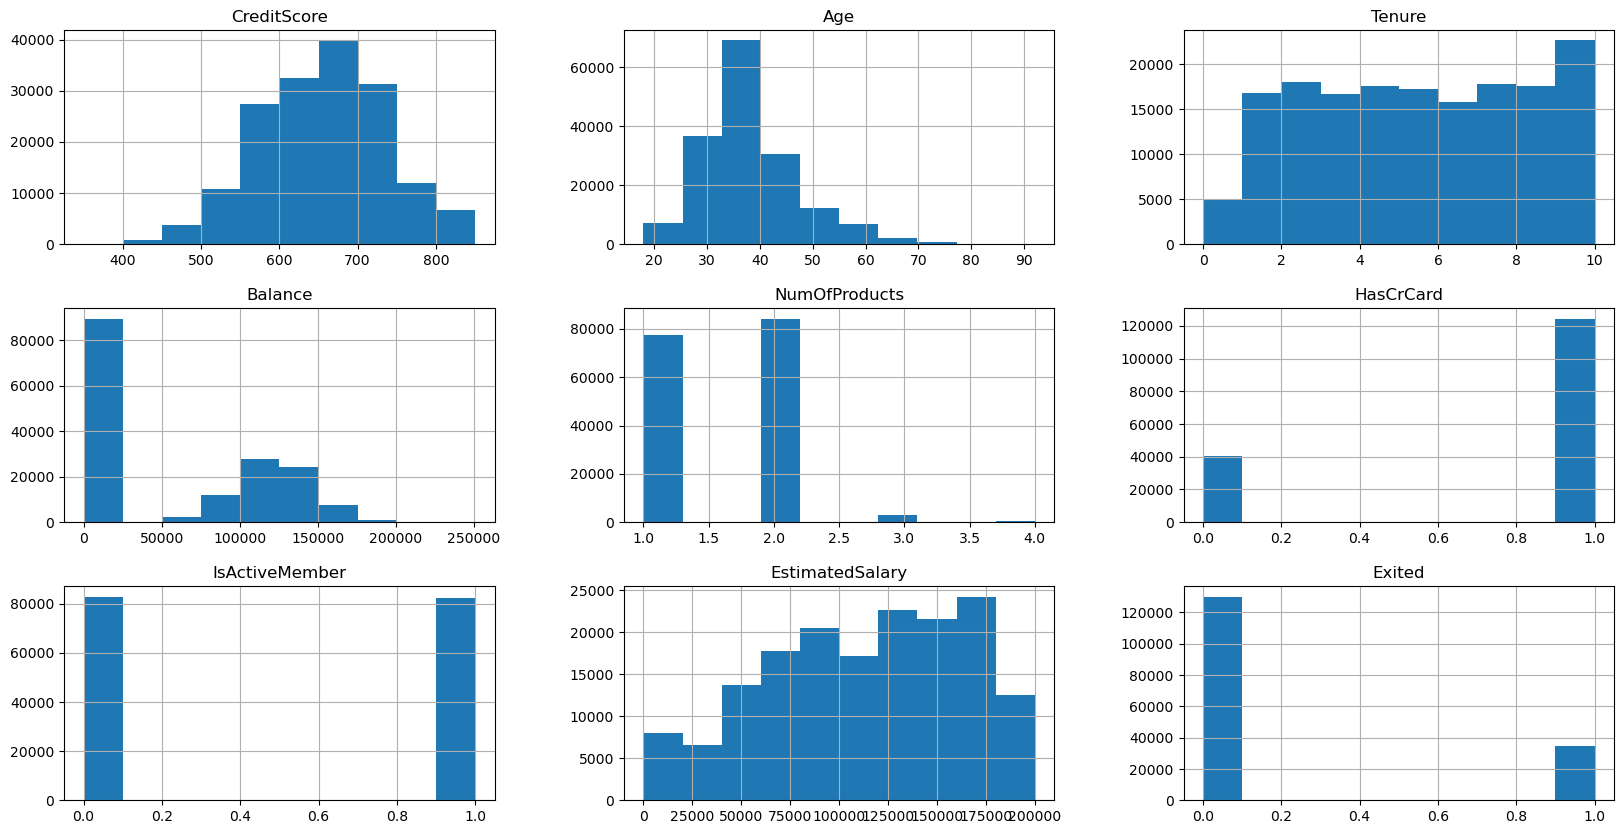

In [15]:
df_train.hist(figsize=(20,10))

In [16]:
df_train['NumOfProducts'].value_counts()

NumOfProducts
2    84291
1    77374
3     2894
4      475
Name: count, dtype: int64

<Axes: >

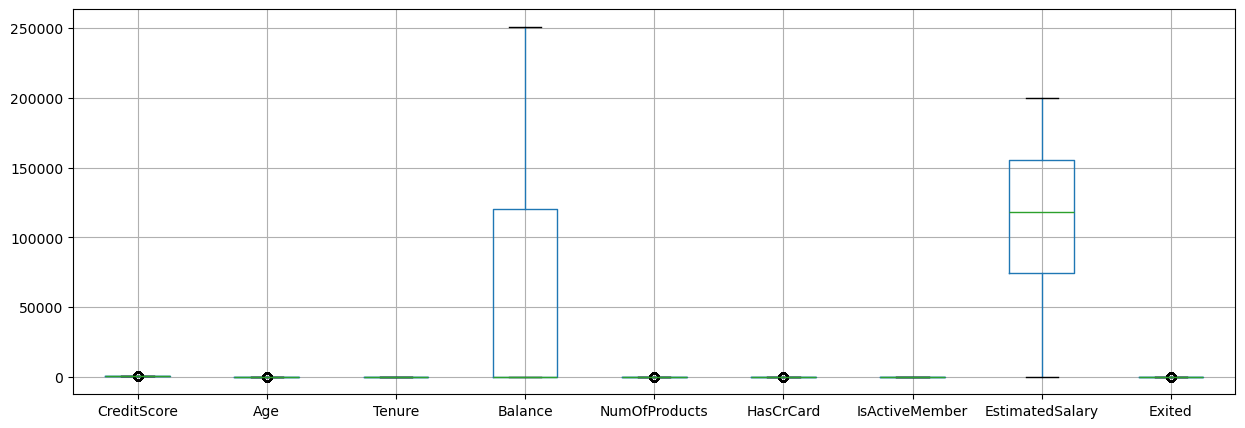

In [17]:
df_train.boxplot(figsize=(15,5))

In [18]:
def graf_func(df,column):
    column= df[column]
    plot = sns.JointGrid(data=df, x=column)
    plot.plot_joint(sns.histplot)
    plot.plot_marginals(sns.boxplot)
    return plot

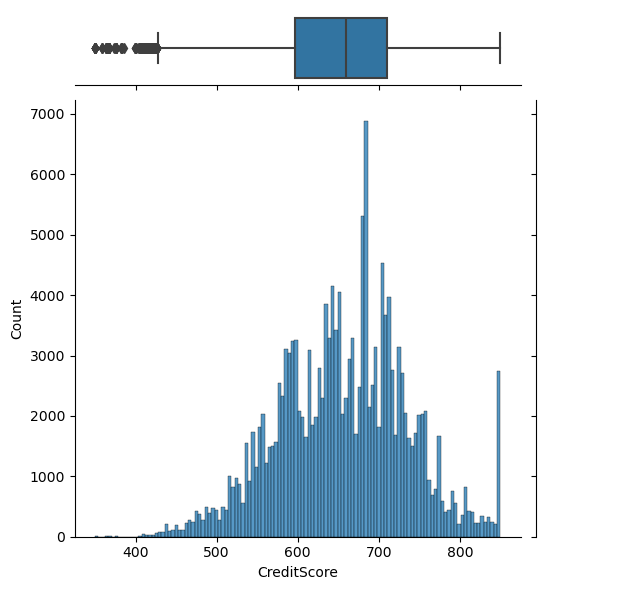

In [19]:
graf_func(df_train,'CreditScore')

In [20]:
outliers.quantileoutlier(df_train,'CreditScore',1.5).max()

427

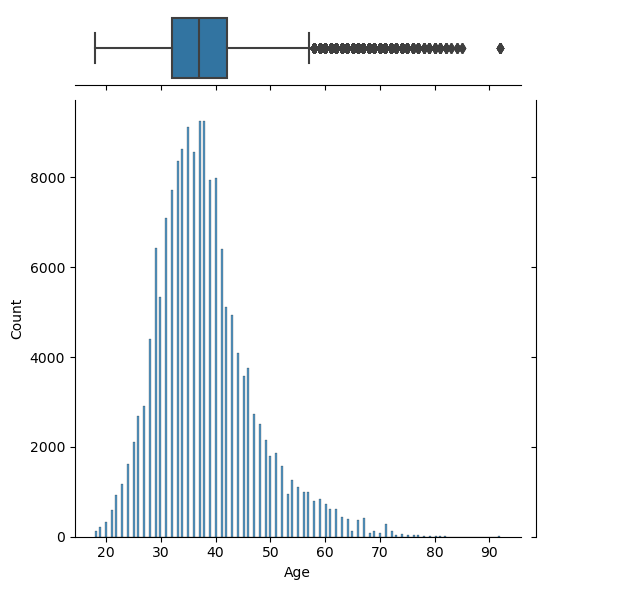

In [21]:
graf_func(df_train,'Age')

In [22]:
outliers.quantileoutlier(df_train,'Age',1.5).min()

58

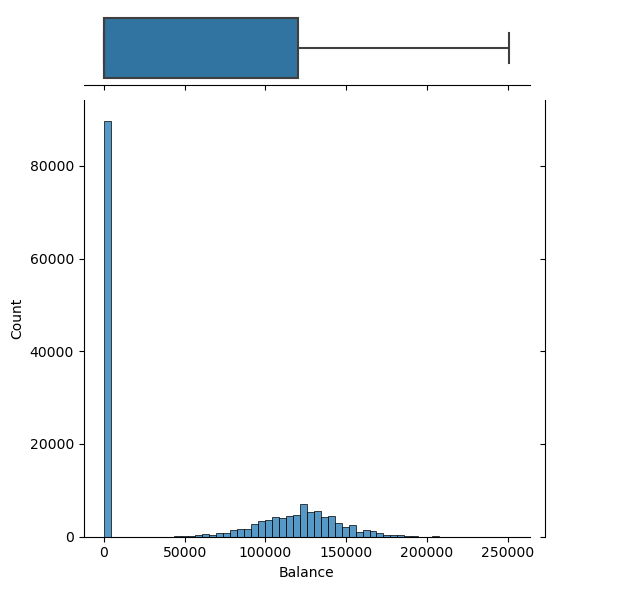

In [23]:
graf_func(df_train,'Balance')

In [24]:
outliers.quantileoutlier(df_train,'Balance',1.5)

Series([], Name: Balance, dtype: float64)

La variable Balance tiene demasiados valores en cero, habrá que analizarlo en siguientes pasos para desglozar su comportamiento con otras variables.

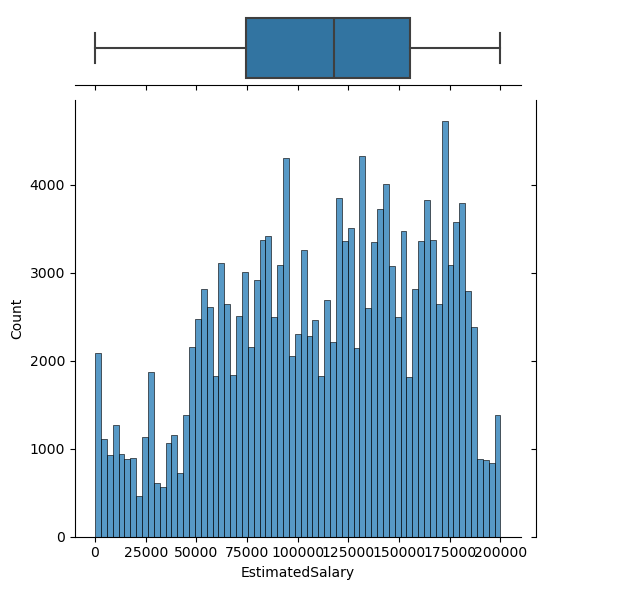

In [25]:
graf_func(df_train,'EstimatedSalary')

In [26]:
outliers.quantileoutlier(df_train,'EstimatedSalary',1.5)

Series([], Name: EstimatedSalary, dtype: float64)

In [27]:
df_isolation= outliers.isolation(df_train,0.1,['CreditScore','Age','Balance','EstimatedSalary'])

D:\Anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [28]:
df_isolation.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,148530.000000,148530.000000,148530.000000,148530.000000,148530.000000,148530.000000,148530.000000,148530.000000,148530.000000
mean,656.318198,37.332451,5.038416,52660.068366,1.544961,0.795328,0.496385,113569.397607,0.154952
std,76.298493,7.991340,2.750676,61941.441021,0.503195,0.403463,0.499989,48915.728972,0.361860
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,599.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,76821.240000,0.000000
50%,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,119333.300000,0.000000
75%,709.000000,41.000000,7.000000,117559.050000,2.000000,1.000000,1.000000,153955.380000,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


<Axes: >

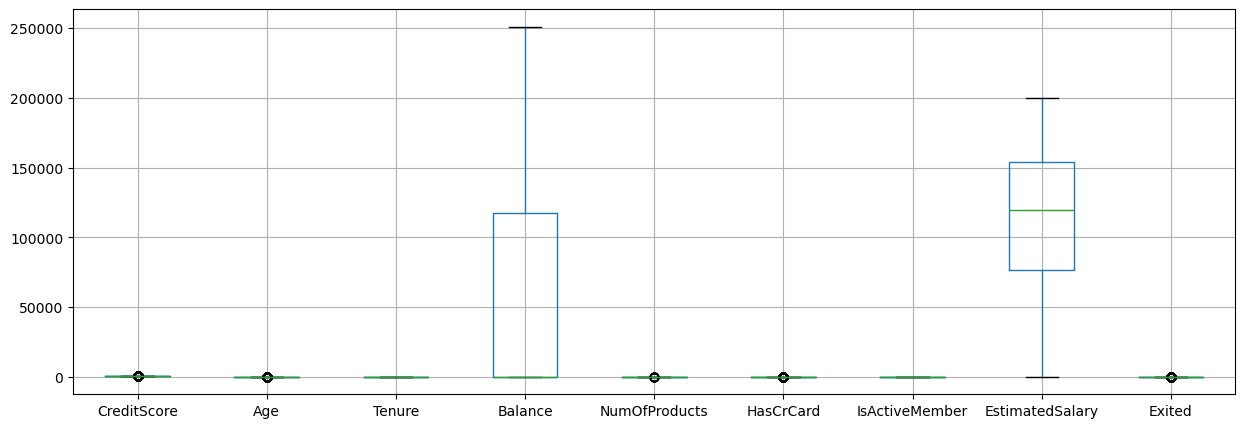

In [29]:
df_isolation.boxplot(figsize=(15,5))

array([[<Axes: title={'center': 'CreditScore'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Tenure'}>],
       [<Axes: title={'center': 'Balance'}>,
        <Axes: title={'center': 'NumOfProducts'}>,
        <Axes: title={'center': 'HasCrCard'}>],
       [<Axes: title={'center': 'IsActiveMember'}>,
        <Axes: title={'center': 'EstimatedSalary'}>,
        <Axes: title={'center': 'Exited'}>]], dtype=object)

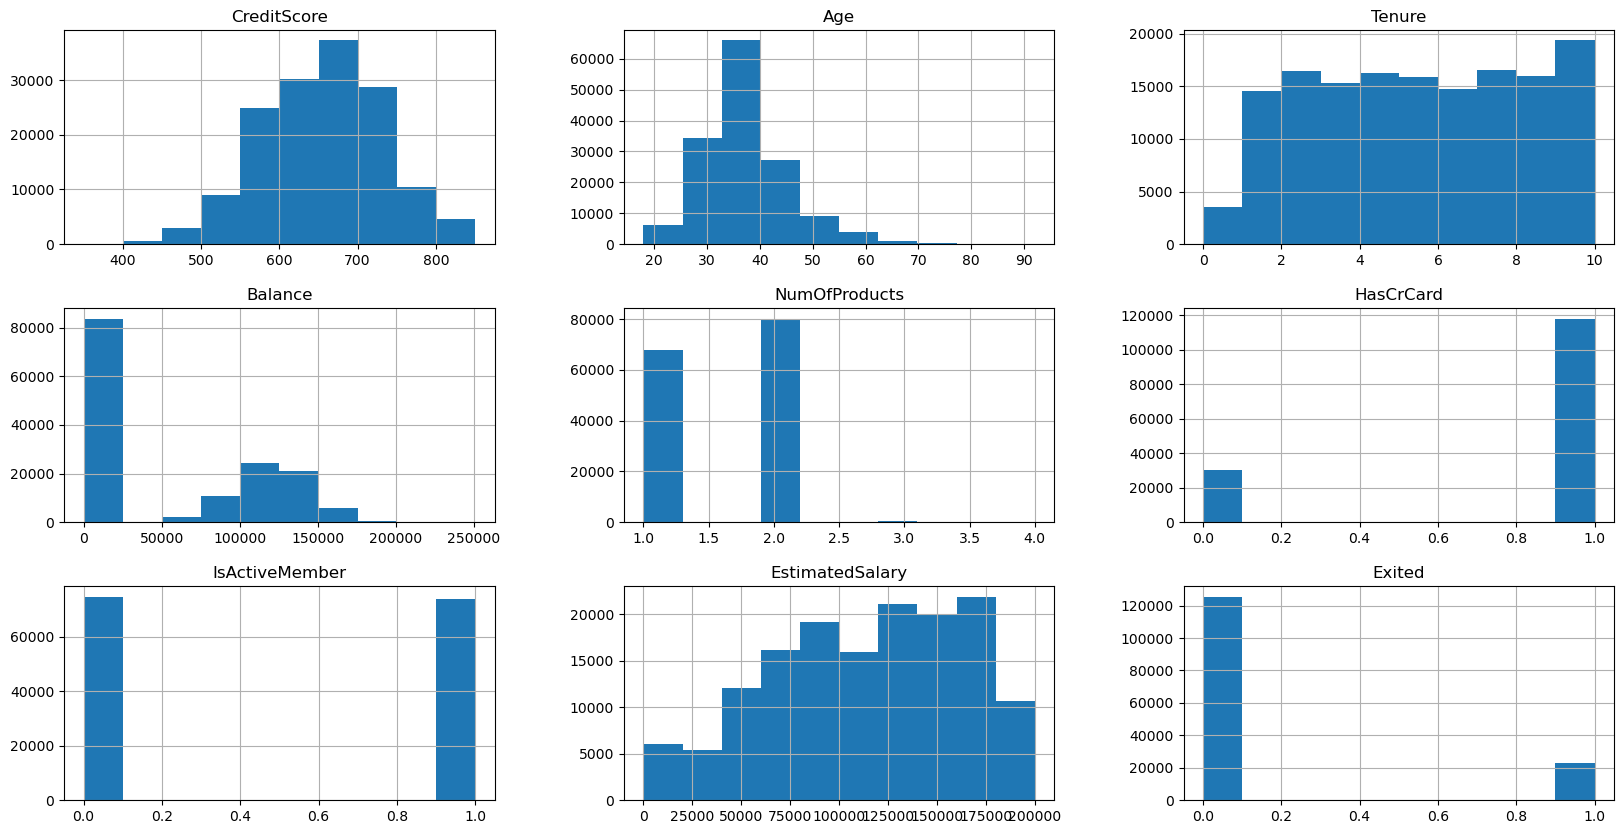

In [30]:
df_isolation.hist(figsize=(20,10))

In [31]:
df_knn= outliers.knn_outliers(df_train,0.1,['CreditScore','Age','Balance','EstimatedSalary'])

In [32]:
df_knn.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,152370.000000,152370.000000,152370.000000,152370.000000,152370.000000,152370.00000,152370.000000,152370.000000,152370.000000
mean,656.360858,38.086894,5.021067,50093.694145,1.573105,0.75488,0.497545,113774.744753,0.208742
std,79.733850,8.843680,2.802904,61330.845002,0.544065,0.43016,0.499996,49426.267554,0.406411
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,598.000000,32.000000,3.000000,0.000000,1.000000,1.00000,0.000000,76615.380000,0.000000
50%,659.000000,37.000000,5.000000,0.000000,2.000000,1.00000,0.000000,120107.100000,0.000000
75%,710.000000,42.000000,7.000000,117020.080000,2.000000,1.00000,1.000000,155853.955000,0.000000
max,850.000000,92.000000,10.000000,238387.560000,4.000000,1.00000,1.000000,199992.480000,1.000000


<Axes: >

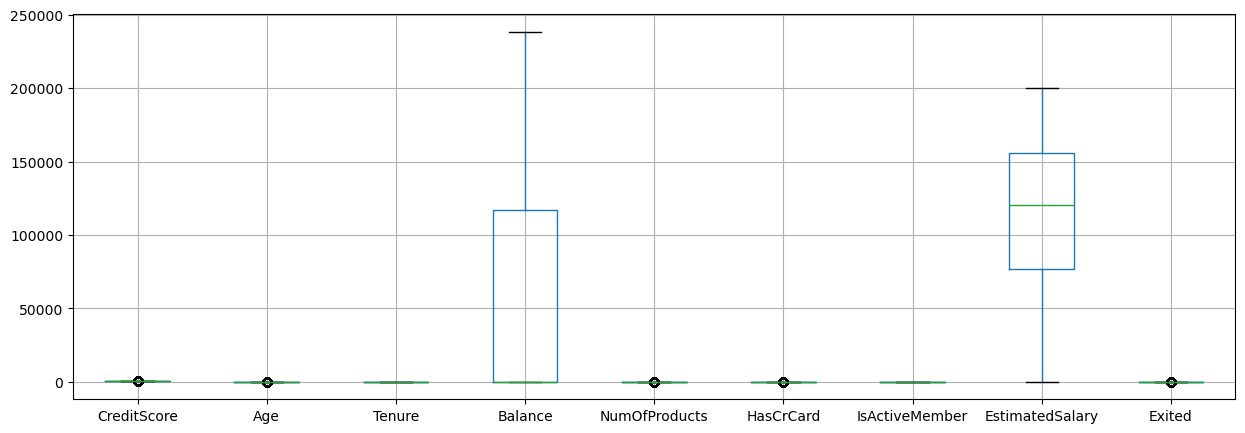

In [33]:
df_knn.boxplot(figsize=(15,5))

array([[<Axes: title={'center': 'CreditScore'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Tenure'}>],
       [<Axes: title={'center': 'Balance'}>,
        <Axes: title={'center': 'NumOfProducts'}>,
        <Axes: title={'center': 'HasCrCard'}>],
       [<Axes: title={'center': 'IsActiveMember'}>,
        <Axes: title={'center': 'EstimatedSalary'}>,
        <Axes: title={'center': 'Exited'}>]], dtype=object)

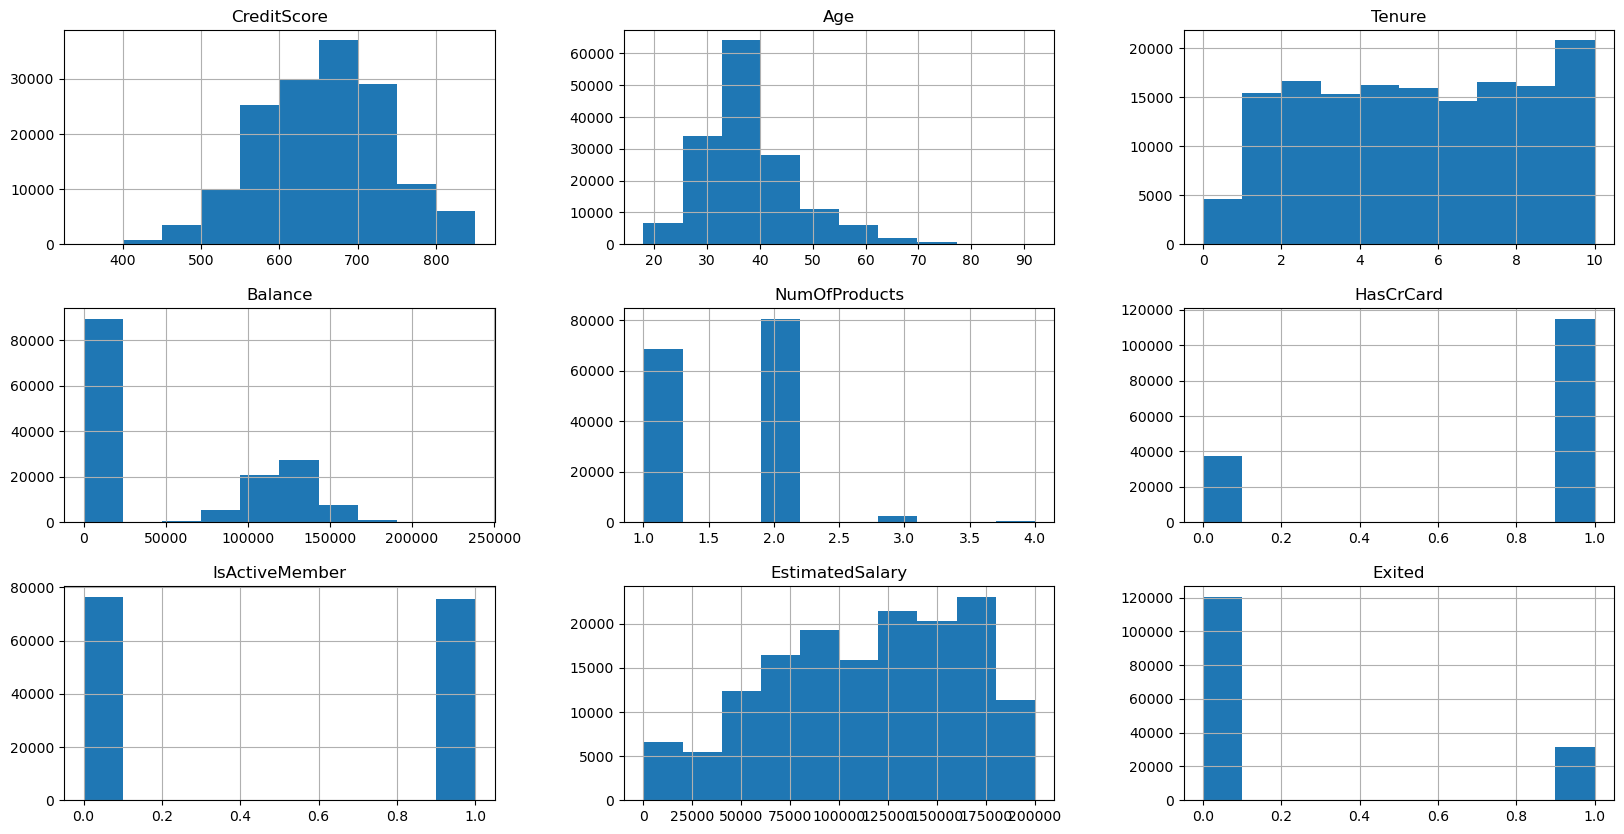

In [34]:
df_knn.hist(figsize=(20,10))

Consideraría eliminar los outliers con la tecnica Quantile pero en este caso, al tener inconsistencia en ciertas variables, mantendre los outliers para realizar el análisis.
Posteriormente, para la construcción del modelo eliminaremos los outliers.

In [35]:
#df_train= df_train[df_train['Age']<58].reset_index(drop=True)

In [36]:
df_train

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,668,France,Male,33,3,0.00,2,1,0,181449.97,0
1,627,France,Male,33,1,0.00,2,1,1,49503.50,0
2,678,France,Male,40,10,0.00,2,1,0,184866.69,0
3,581,France,Male,34,2,148882.54,1,1,1,84560.88,0
4,716,Spain,Male,33,5,0.00,2,1,1,15068.83,0
...,...,...,...,...,...,...,...,...,...,...,...
165029,667,Spain,Female,33,2,0.00,1,1,1,131834.75,0
165030,792,France,Male,35,3,0.00,1,0,0,131834.45,0
165031,565,France,Male,31,5,0.00,1,1,1,127429.56,0
165032,554,Spain,Female,30,7,161533.00,1,0,1,71173.03,0


In [37]:
#df_train= df_train[df_train['CreditScore']>427].reset_index(drop=True)

In [38]:
df_train

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,668,France,Male,33,3,0.00,2,1,0,181449.97,0
1,627,France,Male,33,1,0.00,2,1,1,49503.50,0
2,678,France,Male,40,10,0.00,2,1,0,184866.69,0
3,581,France,Male,34,2,148882.54,1,1,1,84560.88,0
4,716,Spain,Male,33,5,0.00,2,1,1,15068.83,0
...,...,...,...,...,...,...,...,...,...,...,...
165029,667,Spain,Female,33,2,0.00,1,1,1,131834.75,0
165030,792,France,Male,35,3,0.00,1,0,0,131834.45,0
165031,565,France,Male,31,5,0.00,1,1,1,127429.56,0
165032,554,Spain,Female,30,7,161533.00,1,0,1,71173.03,0


In [39]:
df_train['Exited'].value_counts(normalize=True)

Exited
0    0.788401
1    0.211599
Name: proportion, dtype: float64

<Axes: xlabel='Exited', ylabel='count'>

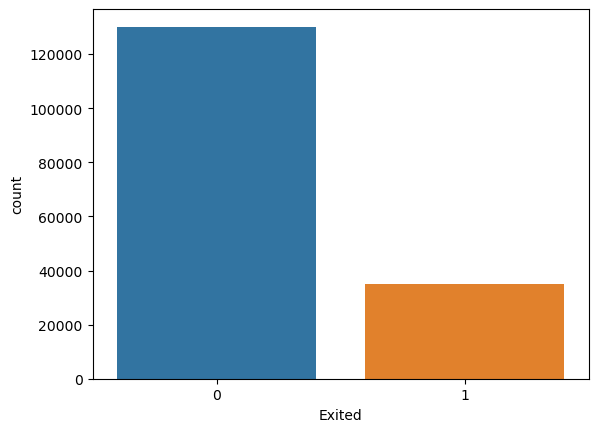

In [40]:
sns.countplot(x=df_train['Exited'])

[<Axes: ylabel='Geography'>, <Axes: ylabel='Gender'>]

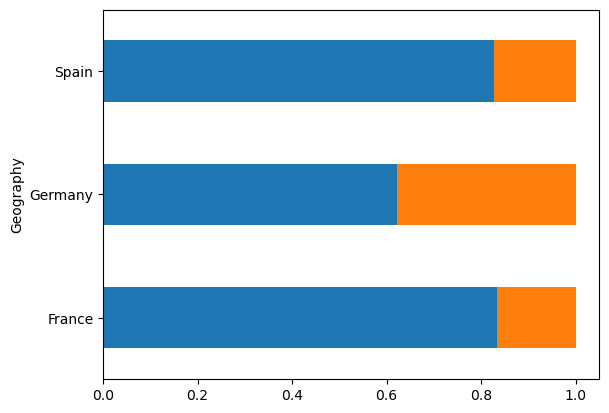

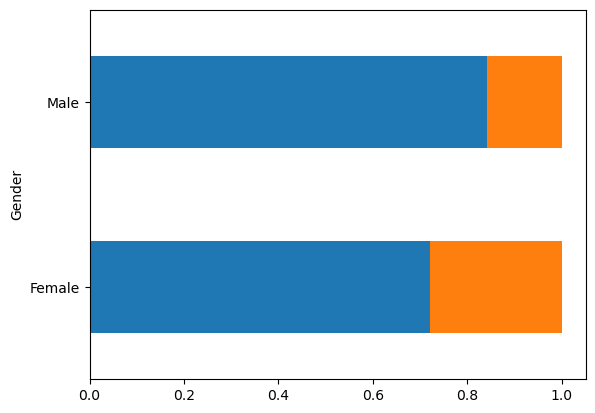

In [41]:
analisis_bi_multi.contingency(df_train,df_train['Exited'])

Gracias al grafico de Contingencia podemos denotar que Germany tiene mayor tasa de Churn o Abandono en contra de los otros dos paises (Spain y France).
Además que Female tiene mayor probabilidad de abandonar.
Esto es interesante, debido a que ciertos cambios dentro de los usuarios puede ser un detonante de abandono.

In [42]:
df_train['Geography'].value_counts()

Geography
France     94215
Spain      36213
Germany    34606
Name: count, dtype: int64

Germany tiene la menor cantidad de observaciones, pero poseé la mayor cantidad de abandono.
Habrá que detallar que sucede en Germany y que variables interactuan con ella.

In [43]:
df_train['Gender'].value_counts()

Gender
Male      93150
Female    71884
Name: count, dtype: int64

In [44]:
df_train= limpieza.categorize(df_train)

### Categorizamos las variables.

In [45]:
df_train['Geography'].value_counts()

Geography
0    94215
1    36213
2    34606
Name: count, dtype: int64

In [46]:
df_train['Gender'].value_counts()

Gender
0    93150
1    71884
Name: count, dtype: int64

In [47]:
df_train['NumOfProducts'].value_counts()

NumOfProducts
2    84291
1    77374
3     2894
4      475
Name: count, dtype: int64

<Axes: xlabel='Gender'>

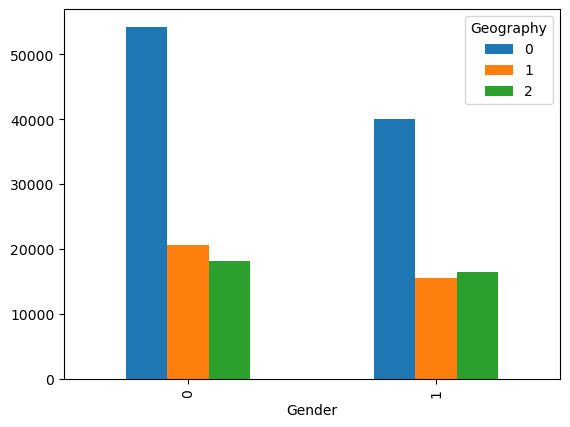

In [48]:
df_train.groupby(['Gender','Geography']).size().unstack().plot(kind='bar',stacked=False)

<Axes: xlabel='Gender', ylabel='Exited'>

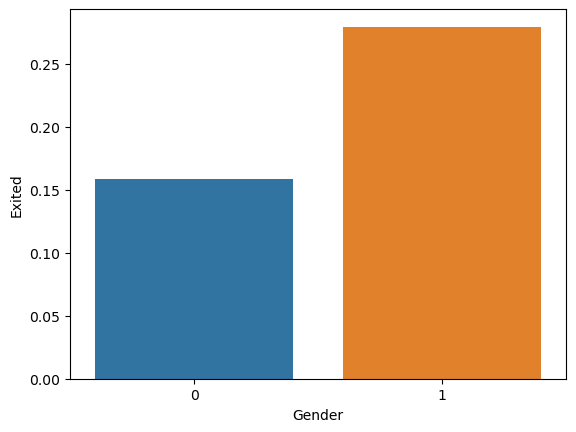

In [49]:
sns.barplot(x="Gender", y="Exited", data=df_train, ci=None)

<Axes: xlabel='Exited'>

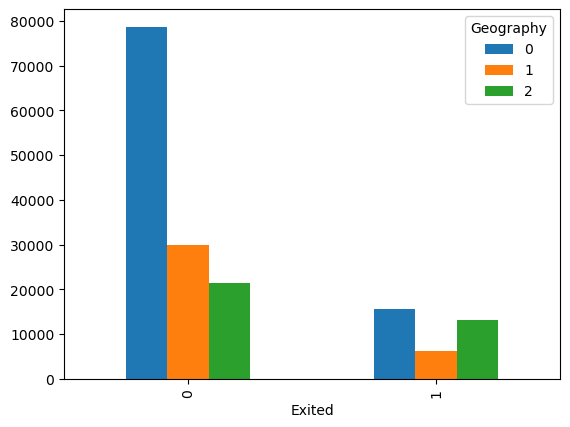

In [50]:
df_train.groupby(['Exited','Geography']).size().unstack().plot(kind='bar',stacked=False)

<Axes: xlabel='Geography', ylabel='Exited'>

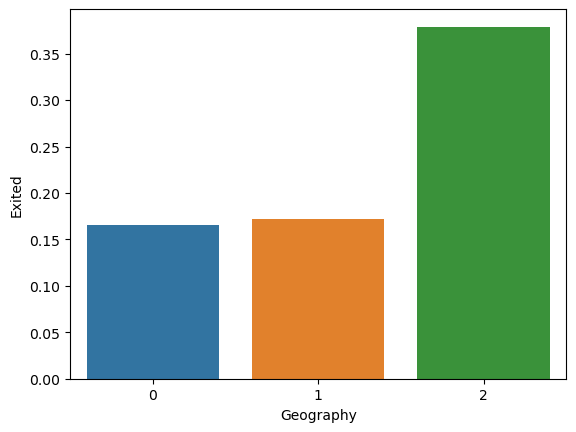

In [51]:
sns.barplot(x="Geography", y="Exited", data=df_train, ci=None)

Como se menciona con anterioridad, Germany (2) tiene mayor probabilidad de Exited.

<Axes: xlabel='Exited'>

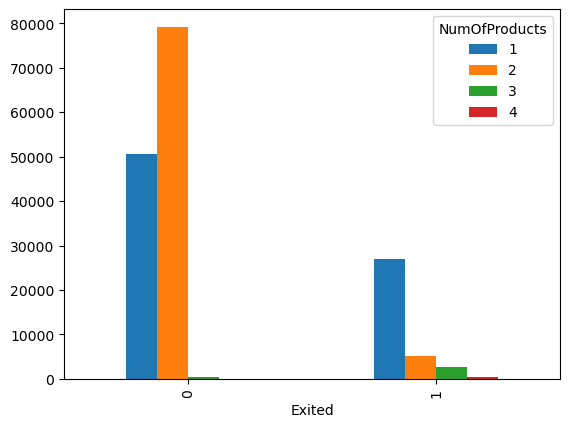

In [52]:
df_train.groupby(['Exited','NumOfProducts']).size().unstack().plot(kind='bar',stacked=False)

<Axes: xlabel='NumOfProducts', ylabel='Exited'>

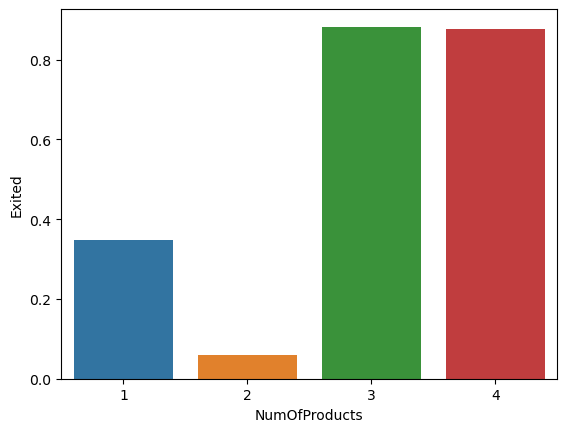

In [53]:
sns.barplot(x="NumOfProducts", y="Exited", data=df_train, ci=None)

Quien posee mayor NumOfProducts tiene mayor probabilidad de abandono, posteriormente lo analizaremos con WOE para ver la distribución.

<Axes: xlabel='Exited'>

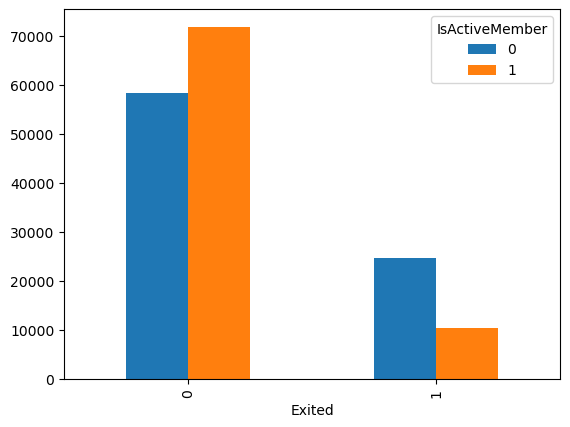

In [54]:
df_train.groupby(['Exited','IsActiveMember']).size().unstack().plot(kind='bar',stacked=False)

<Axes: xlabel='IsActiveMember', ylabel='Exited'>

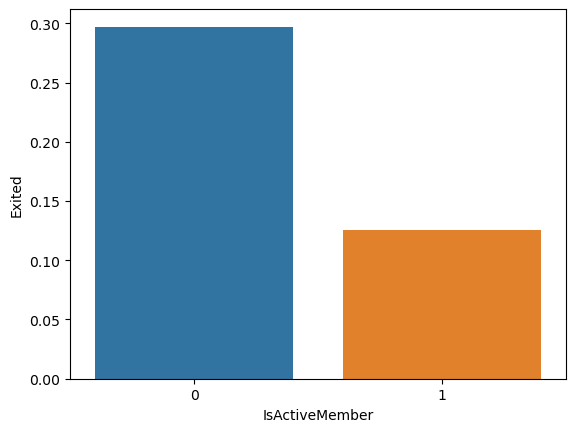

In [55]:
sns.barplot(x="IsActiveMember", y="Exited", data=df_train, ci=None)

Si es un miembro activo tiene un efecto positivo.

In [56]:
X= df_train.drop(columns=['Exited']).astype('int64')
X = sm.add_constant(X)
y = df_train['Exited']

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Exited   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     4750.
Date:                Mon, 05 Aug 2024   Prob (F-statistic):               0.00
Time:                        19:51:49   Log-Likelihood:                -65528.
No. Observations:              165034   AIC:                         1.311e+05
Df Residuals:                  165023   BIC:                         1.312e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0508      0.009     

Analizamos los coeficientes de la regresión previamente ejecutada, podemos observar que los coeficientes de Geography, Gender, Age y EstimatedSalary son positivos.
Se interpretan como las variables que tiene

In [57]:
X= df_train.drop(columns=['Exited']).astype('int64')
X = sm.add_constant(X)
y = df_train['Exited']

# Crear términos de interacción entre 'region' y 'gender'
X['HasCrCard_Balance_interaction'] = X['HasCrCard'] * X['Balance']
X['Region_Balance_interaction'] = X['Geography'] * X['Balance']
X['Age_Balance_interaction'] = X['Age'] * X['Balance']


model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Exited   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     3755.
Date:                Mon, 05 Aug 2024   Prob (F-statistic):               0.00
Time:                        19:51:49   Log-Likelihood:                -65017.
No. Observations:              165034   AIC:                         1.301e+05
Df Residuals:                  165020   BIC:                         1.302e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

Podemos observar que la interacción HasCrCard y Balance tiene un efecto.

AttributeError: 'int' object has no attribute 'startswith'

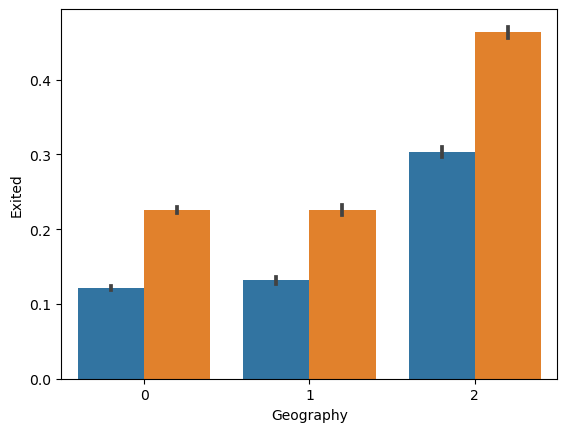

In [58]:
sns.barplot(x='Geography', y='Exited', hue='Gender', data=df_train)

In [59]:
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association

In [60]:
contingency_table1= pd.crosstab([df_train['Geography'],df_train['Balance']],df_train['Exited'])

chi,p,dof,expected= chi2_contingency(contingency_table1)
print(chi, p)

51798.399100604765 0.0


In [61]:
association(contingency_table1)

0.5602365717296007

In [62]:
contingency_table2= pd.crosstab([df_train['Gender']],df_train['Exited'])

chi,p,dof,expected= chi2_contingency(contingency_table2)
print(chi, p)

3538.4525498496996 0.0


In [63]:
association(contingency_table2)

0.14644155895393066

In [64]:
contingency_table3= pd.crosstab([df_train['Geography']],df_train['Balance'])

chi,p,dof,expected= chi2_contingency(contingency_table3)
print(chi, p)

134583.76332898042 0.0


In [65]:
association(contingency_table3)

0.6385495795527862

In [66]:
contingency_table= pd.crosstab([df_train['Geography']],df_train['EstimatedSalary'])

chi,p,dof,expected= chi2_contingency(contingency_table)
print(chi, p)

132739.58670106618 0.0


<Axes: xlabel='Geography', ylabel='EstimatedSalary'>

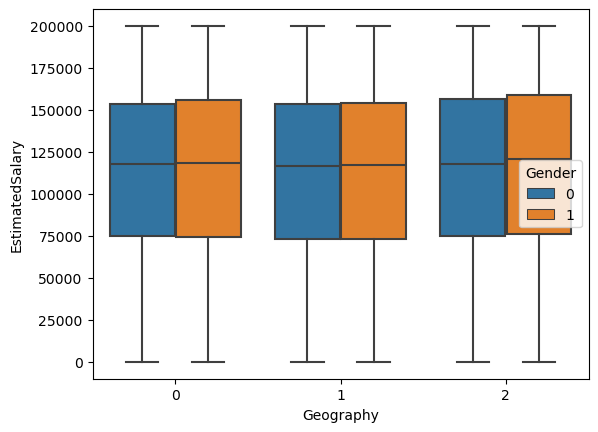

In [67]:
sns.boxplot(x='Geography',y='EstimatedSalary',hue='Gender', data=df_train)

<Axes: xlabel='Geography', ylabel='EstimatedSalary'>

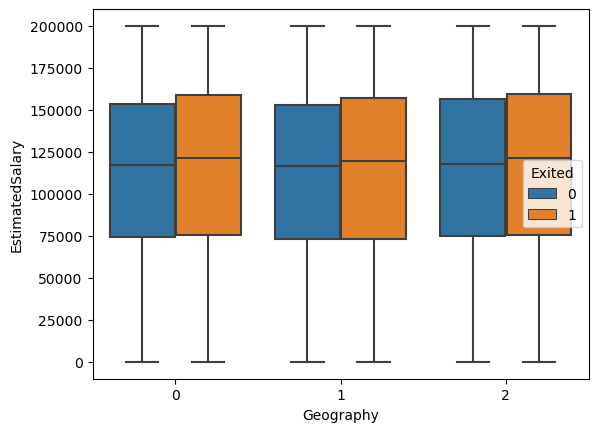

In [68]:
sns.boxplot(x='Geography',y='EstimatedSalary',hue='Exited', data=df_train)

<Axes: xlabel='Geography', ylabel='Balance'>

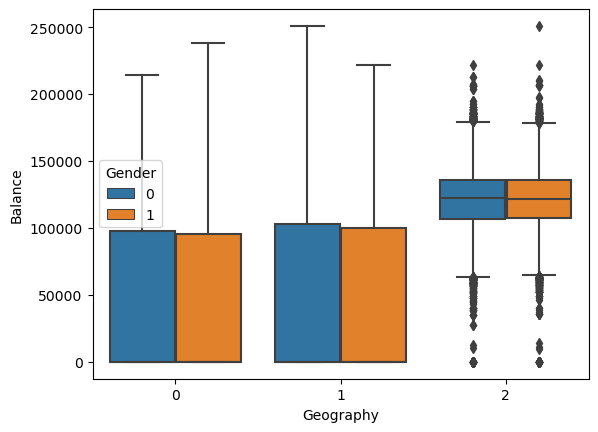

In [69]:
sns.boxplot(x='Geography',y='Balance',hue='Gender', data=df_train)

<Axes: xlabel='Geography', ylabel='Balance'>

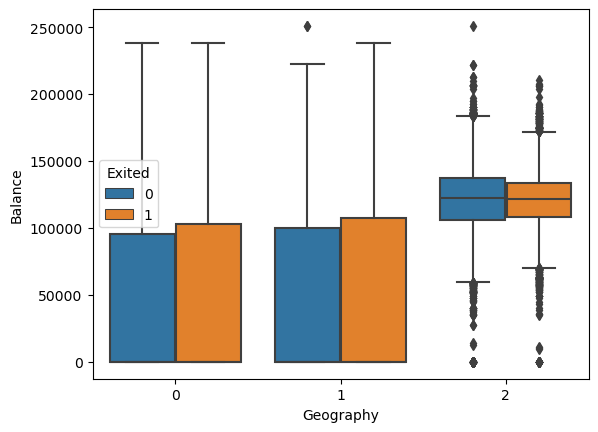

In [70]:
sns.boxplot(x='Geography',y='Balance',hue='Exited', data=df_train)

Una mayor distribucion de datos dentro de la Region 2 dentro de la variable Balance, hay mayor disperción de datos, habra que analizar el desvio estandar.

<Axes: xlabel='HasCrCard', ylabel='Balance'>

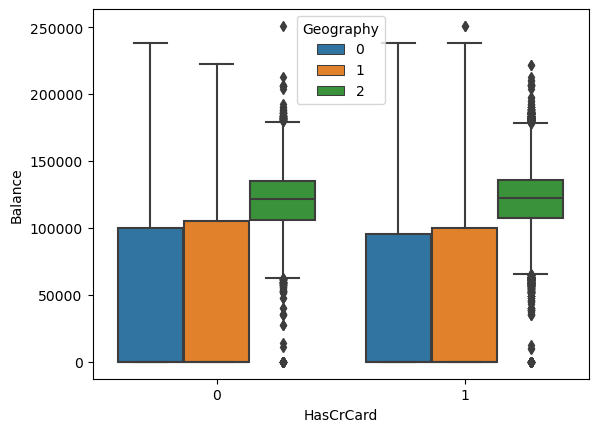

In [71]:
sns.boxplot(x='HasCrCard',y='Balance', hue='Geography',data=df_train)

<Axes: xlabel='HasCrCard', ylabel='Exited'>

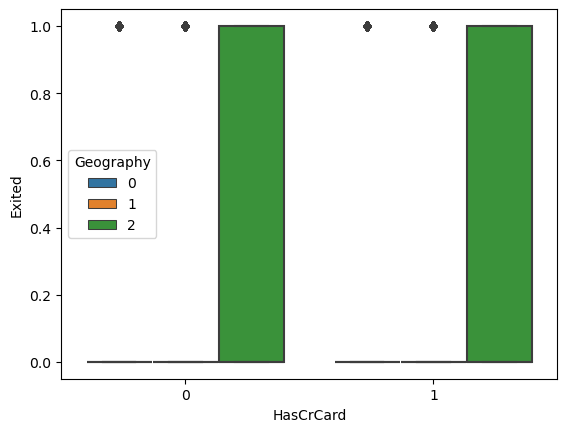

In [72]:
sns.boxplot(x='HasCrCard',y='Exited', hue='Geography',data=df_train)

Al igual con HasCrCard dentro de la región 2 del data set.

<Axes: xlabel='Geography', ylabel='NumOfProducts'>

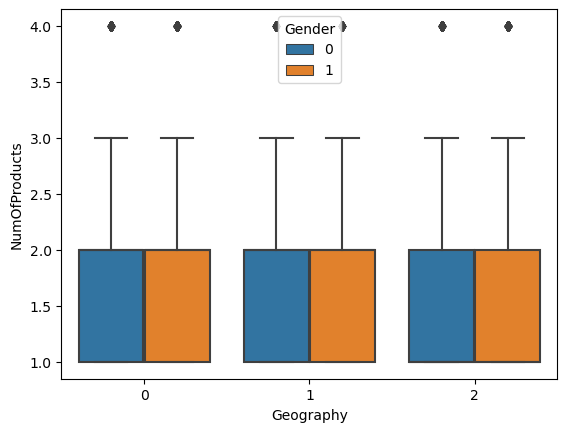

In [73]:
sns.boxplot(x='Geography',y='NumOfProducts',hue='Gender', data=df_train)

<Axes: xlabel='Geography', ylabel='NumOfProducts'>

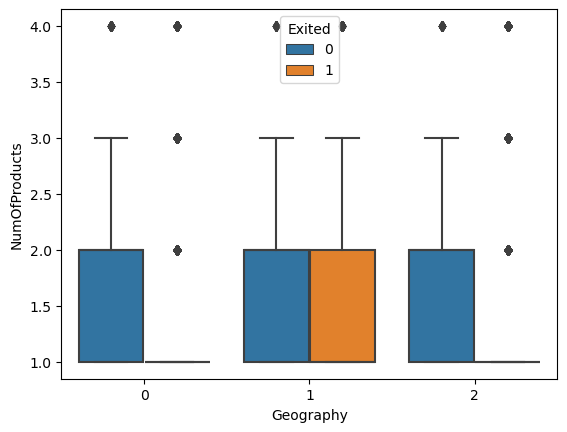

In [74]:
sns.boxplot(x='Geography',y='NumOfProducts',hue='Exited', data=df_train)

<Axes: xlabel='Geography', ylabel='Tenure'>

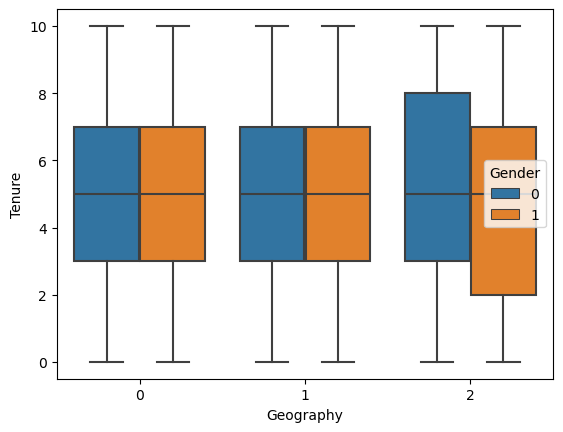

In [75]:
sns.boxplot(x='Geography',y='Tenure',hue='Gender', data=df_train)

<Axes: xlabel='Geography', ylabel='Tenure'>

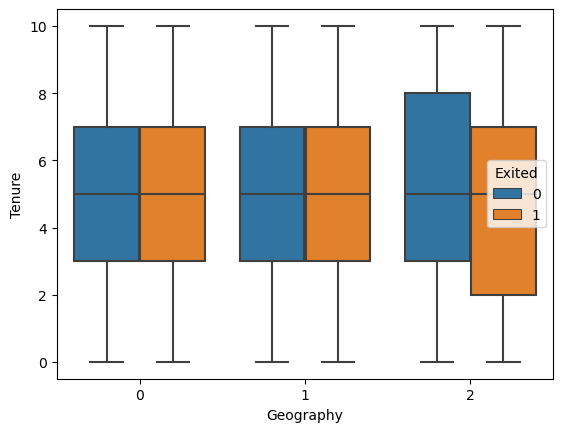

In [76]:
sns.boxplot(x='Geography',y='Tenure',hue='Exited', data=df_train)

## Analisis de Geography 2

Analizaremos independientemente Germany para ver el grupo exclusivamente y que comportamientos tiene dentro de la región.

In [77]:
region2= df_train[df_train['Geography']==2]

In [78]:
region2

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
5,588,2,0,36,4,131778.58,1,1,0,136024.31,1
9,583,2,0,40,4,81274.33,1,1,1,170843.07,0
10,599,2,1,27,6,161801.47,2,1,0,109184.24,0
11,687,2,0,40,3,90432.92,1,1,0,1676.92,0
18,645,2,1,55,8,120105.43,1,1,0,125083.29,1
...,...,...,...,...,...,...,...,...,...,...,...
165009,708,2,1,35,6,140791.57,2,1,1,102083.73,0
165012,746,2,1,60,3,108805.42,2,1,0,78744.37,1
165014,676,2,1,29,4,139825.34,2,1,1,116672.02,0
165024,592,2,1,33,3,110993.29,2,1,1,176747.66,1


In [79]:
region2.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,34606.000000,34606.000000,34606.000000,34606.000000,34606.000000,34606.000000,34606.000000,34606.000000,34606.000000
mean,656.920274,39.729209,4.978125,121235.738547,1.445010,0.749783,0.462405,113873.187463,0.378952
std,80.955772,9.148677,2.844394,23216.744492,0.583025,0.433144,0.498592,50046.661973,0.485133
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,597.000000,33.000000,3.000000,106947.450000,1.000000,0.000000,0.000000,74899.200000,0.000000
50%,657.000000,39.000000,5.000000,122028.650000,1.000000,1.000000,0.000000,119439.660000,0.000000
75%,712.000000,45.000000,7.000000,135827.405000,2.000000,1.000000,1.000000,157921.815000,1.000000
max,850.000000,83.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [80]:
region2['Exited'].value_counts()

Exited
0    21492
1    13114
Name: count, dtype: int64

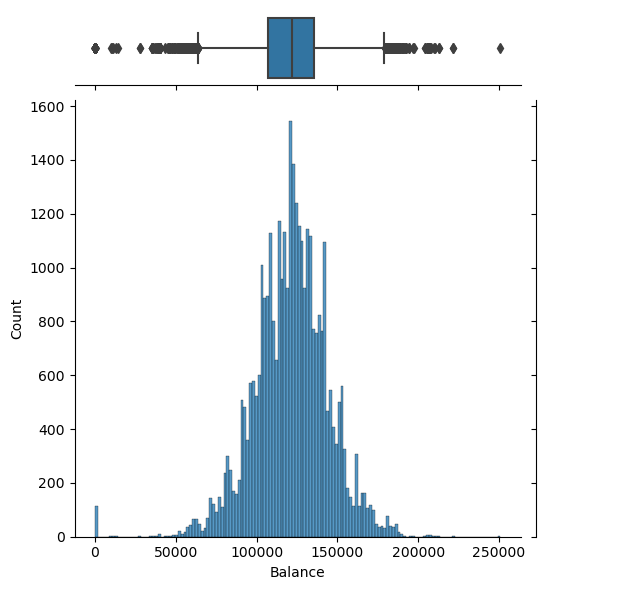

In [81]:
graf_func(region2,'Balance')

In [82]:
outliers.quantileoutlier(region2,'Balance',1.5).quantile(.75)

182355.2

In [83]:
outliers.quantileoutlier(region2,'Balance',1.5).quantile(.25)

52384.8025

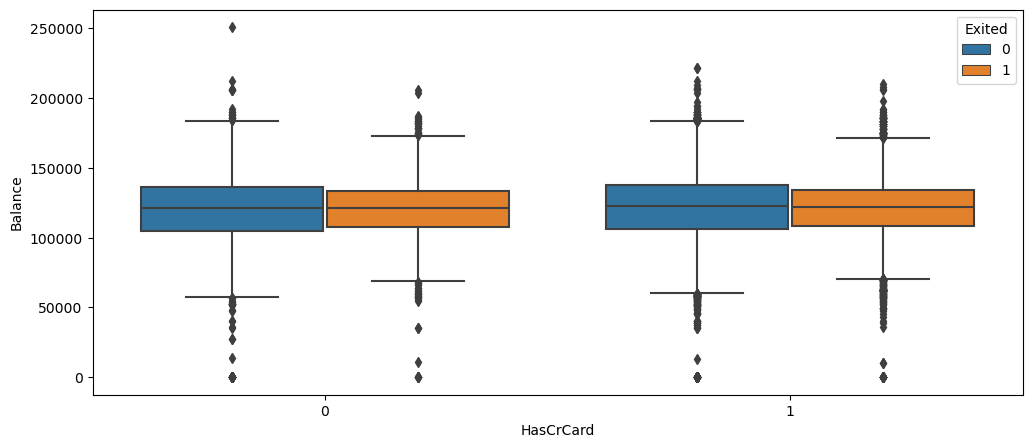

In [84]:
plt.figure(figsize=(12,5))
sns.boxplot(x='HasCrCard', y='Balance',hue='Exited',data=region2)
plt.show()

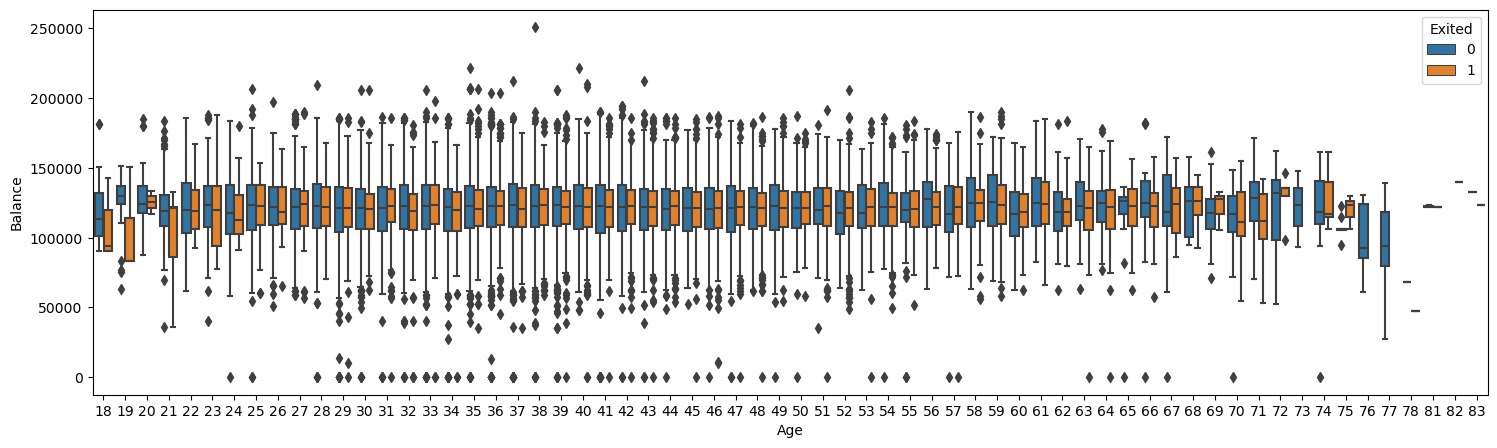

In [85]:
plt.figure(figsize=(18,5))
sns.boxplot(x='Age', y='Balance',hue='Exited',data=region2)
plt.show()

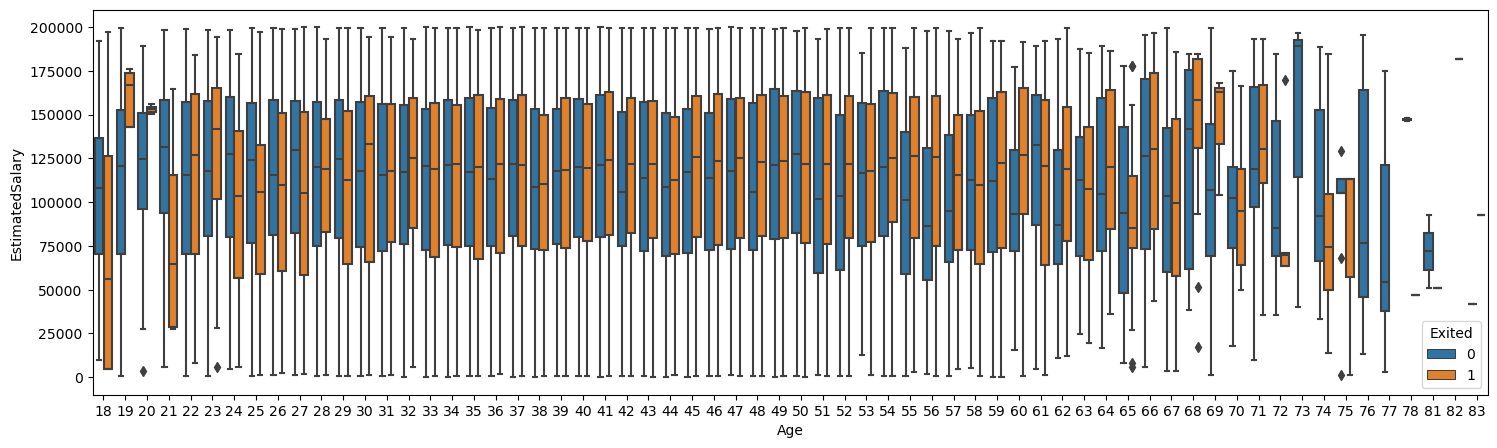

In [86]:
plt.figure(figsize=(18,5))
sns.boxplot(x='Age', y='EstimatedSalary',hue='Exited',data=region2)
plt.show()

In [87]:
X= region2.drop(columns=['Exited']).astype('int64')
X = sm.add_constant(X)
y = region2['Exited']

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Exited   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     1237.
Date:                Mon, 05 Aug 2024   Prob (F-statistic):               0.00
Time:                        19:54:52   Log-Likelihood:                -19243.
No. Observations:               34606   AIC:                         3.851e+04
Df Residuals:                   34596   BIC:                         3.859e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
CreditScore        -0.0001    2.8e-05     

In [92]:
X= region2.drop(columns=['Exited']).astype('int64')
X = sm.add_constant(X) 
y = region2['Exited']

X['HasCrCard_Balance_interaction'] = X['HasCrCard'] * X['Balance']

model = sm.OLS(y, X, hasconst=True)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Exited   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     1114.
Date:                Mon, 05 Aug 2024   Prob (F-statistic):               0.00
Time:                        19:54:56   Log-Likelihood:                -19240.
No. Observations:               34606   AIC:                         3.850e+04
Df Residuals:                   34595   BIC:                         3.859e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
CreditScore   

In [93]:
analisis_bi_multi.correlation(region2,'Exited')

D:\Anaconda\Lib\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


,Correlation,P-Value
CreditScore,-0.030625,1.210985e-08
Geography,NaN,NaN
Gender,0.165316,1.580016e-210
Age,0.420309,0.000000e+00
Tenure,-0.026184,1.107436e-06
Balance,-0.005887,2.734589e-01
NumOfProducts,-0.249384,0.000000e+00
HasCrCard,-0.007104,1.863320e-01
IsActiveMember,-0.264622,0.000000e+00
EstimatedSalary,0.019848,2.220239e-04


<Axes: >

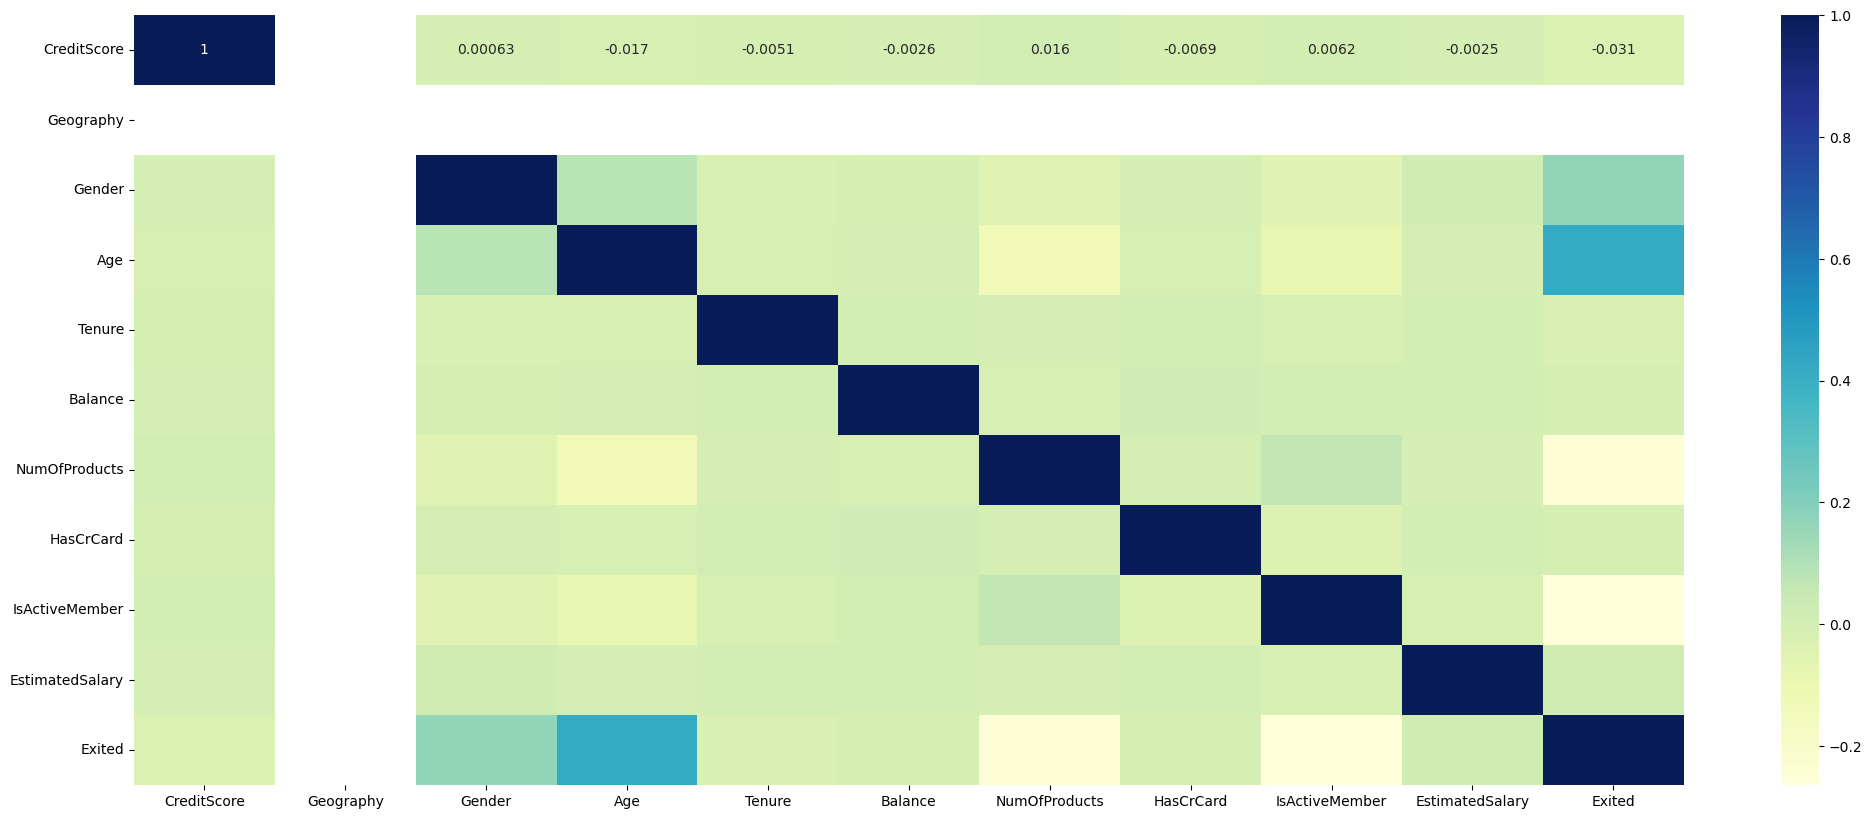

In [94]:
correlation= region2.astype('int64').corr(method='spearman')
plt.figure(figsize=(25,10))
sns.heatmap(correlation, annot=True, cmap= 'YlGnBu')

In [95]:
analisis_bi_multi.varclus(region2.drop(columns=['Geography']))

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio
0,0,Age,0.695015,0.008265,0.307526
1,0,Exited,0.695015,0.070025,0.327949
2,1,HasCrCard,1.000000,0.001569,0.000000
3,2,CreditScore,1.000000,0.000632,0.000000
4,3,EstimatedSalary,1.000000,0.000275,0.000000
5,4,Tenure,1.000000,0.000668,0.000000
6,5,Balance,1.000000,0.000383,0.000000
7,6,NumOfProducts,1.000000,0.024447,0.000000
8,7,IsActiveMember,1.000000,0.036431,0.000000
9,8,Gender,1.000000,0.021590,0.000000


In [96]:
analisis_bi_multi.woenum(region2,region2['Exited'])

{'CreditScore':                      Bin  Count  Count (%)  Non-event  Event  Event rate  \
 0         (-inf, 560.50)   4129   0.119315       2463   1666    0.403488   
 1       [560.50, 649.50)  11897   0.343784       7189   4708    0.395730   
 2       [649.50, 666.50)   2416   0.069814       1494    922    0.381623   
 3       [666.50, 771.50)  13647   0.394354       8659   4988    0.365502   
 4          [771.50, inf)   2517   0.072733       1687    830    0.329758   
 5                Special      0   0.000000          0      0    0.000000   
 6                Missing      0   0.000000          0      0    0.000000   
 Totals                    34606   1.000000      21492  13114    0.378952   
 
              WoE        IV        JS  
 0      -0.103046  0.001282  0.000160  
 1      -0.070712  0.001733  0.000217  
 2      -0.011333  0.000009  0.000001  
 3       0.057564  0.001297  0.000162  
 4       0.215281  0.003273  0.000408  
 5            0.0  0.000000  0.000000  
 6        

In [97]:
analisis_bi_multi.woecat(region2,region2['Exited'])

{'Geography':             Bin  Count  Count (%)  Non-event  Event  Event rate  WoE   IV   JS
 0           [2]  34606        1.0      21492  13114    0.378952 -0.0  0.0  0.0
 1       Special      0        0.0          0      0    0.000000  0.0  0.0  0.0
 2       Missing      0        0.0          0      0    0.000000  0.0  0.0  0.0
 Totals           34606        1.0      21492  13114    0.378952       0.0  0.0,
 'Gender':             Bin  Count  Count (%)  Non-event  Event  Event rate       WoE  \
 0           [0]  18218   0.526441      12700   5518    0.302887  0.339586   
 1           [1]  16388   0.473559       8792   7596    0.463510  -0.34778   
 2       Special      0   0.000000          0      0    0.000000       0.0   
 3       Missing      0   0.000000          0      0    0.000000       0.0   
 Totals           34606   1.000000      21492  13114    0.378952             
 
               IV        JS  
 0       0.057779  0.007188  
 1       0.059173  0.007360  
 2       0.00000

Para la región 2, las variables que demuestran mayor importancia dado el Information Value son las siguientes:
* Gender, Age, NumOfProducts, IsActiveMember.

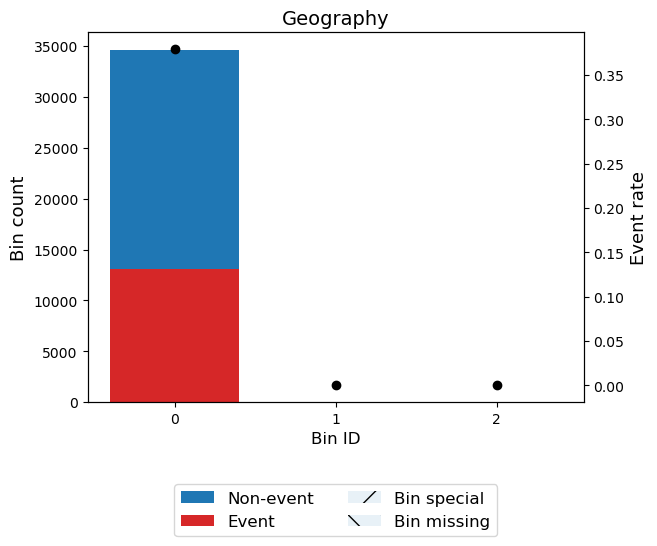

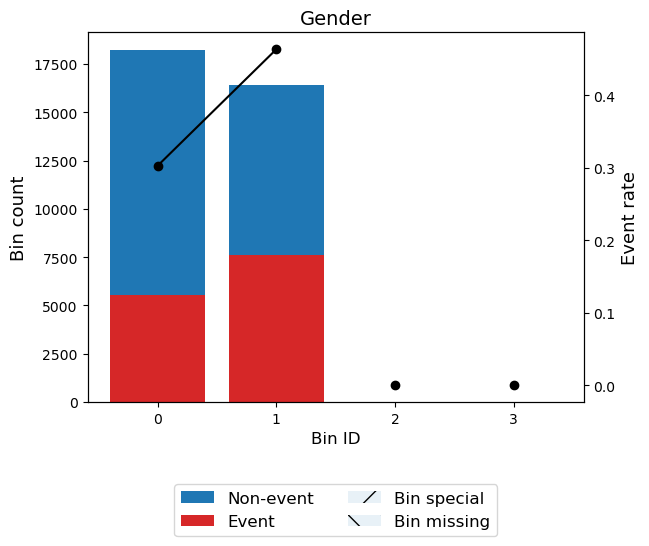

[None, None]

In [98]:
analisis_bi_multi.woegrafcat(region2,region2['Exited'])

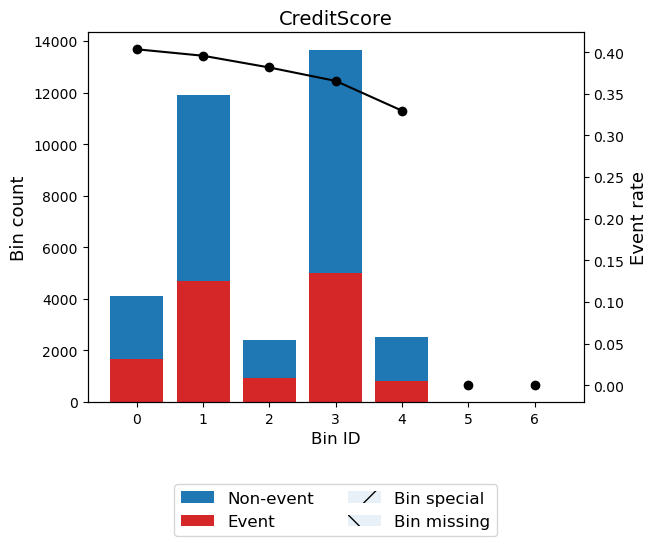

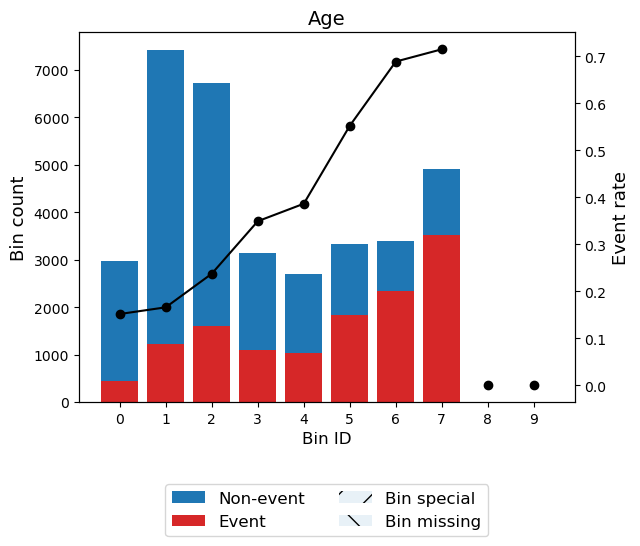

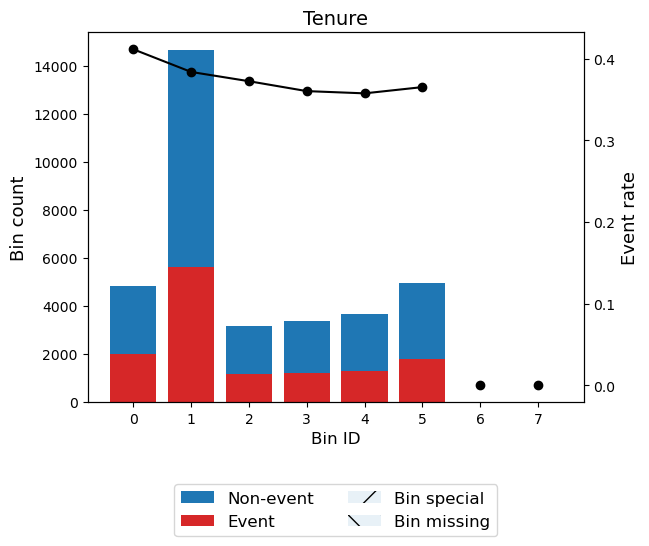

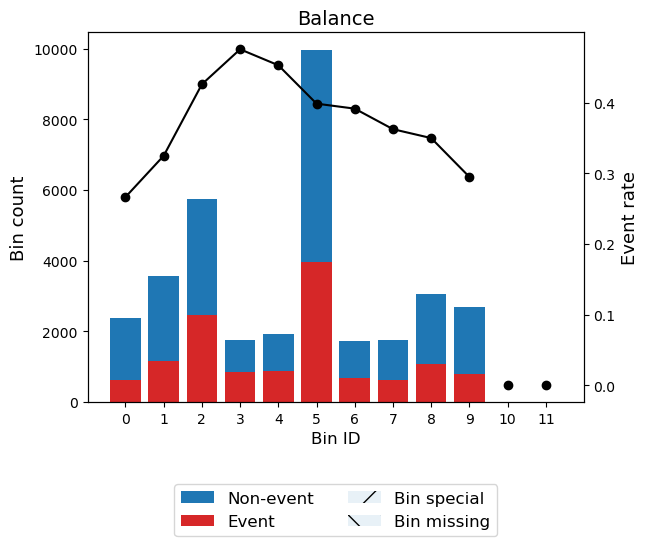

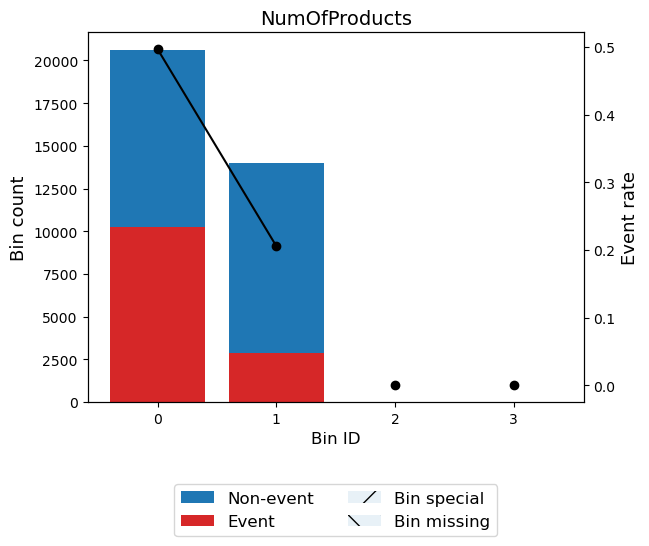

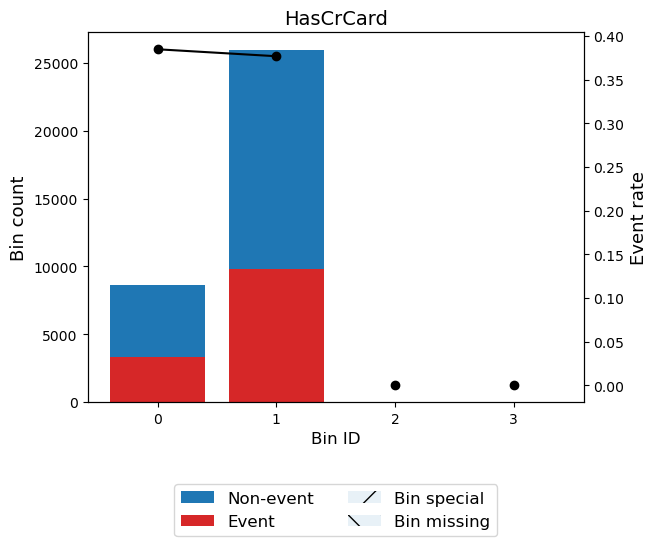

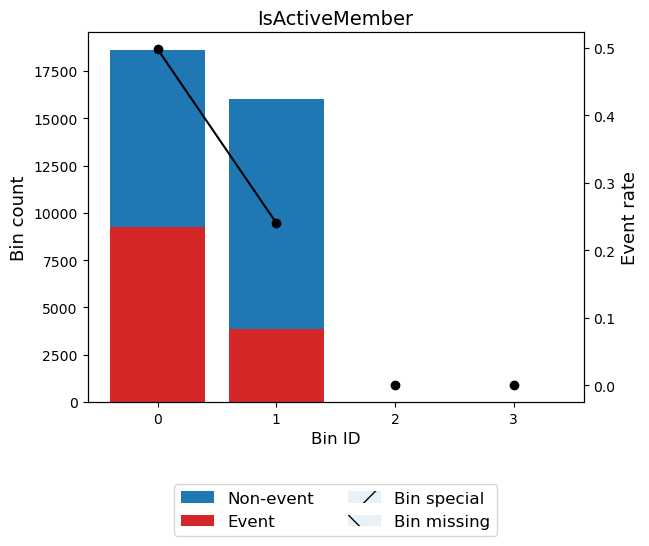

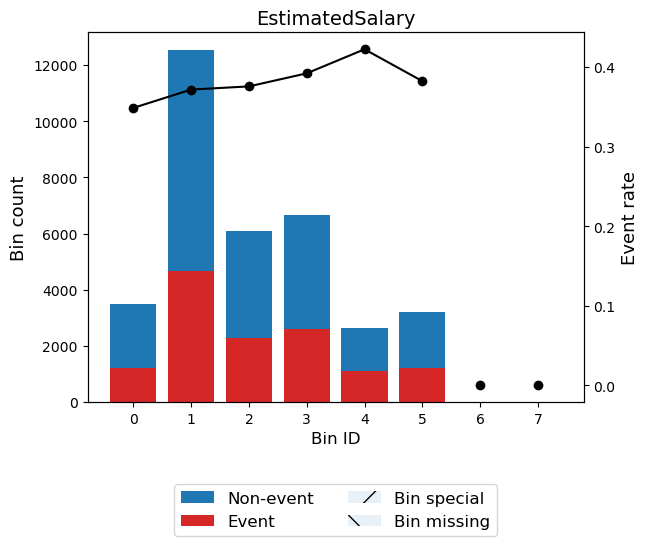

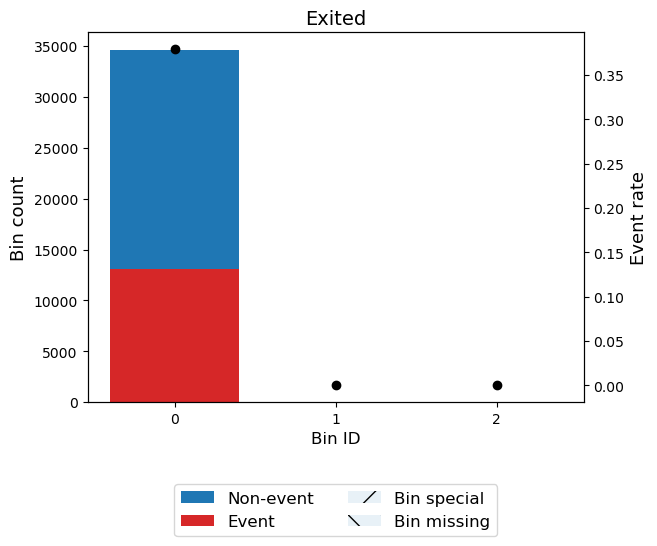

[None, None, None, None, None, None, None, None, None]

In [99]:
analisis_bi_multi.woegrafnum(region2,region2['Exited'])

### Analisis sin la región 2 en Geography

In [100]:
region01= df_train[df_train['Geography']!=2]

In [101]:
region01['Exited'].value_counts()

Exited
0    108621
1     21807
Name: count, dtype: int64

In [102]:
region2.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,34606.000000,34606.000000,34606.000000,34606.000000,34606.000000,34606.000000,34606.000000,34606.000000,34606.000000
mean,656.920274,39.729209,4.978125,121235.738547,1.445010,0.749783,0.462405,113873.187463,0.378952
std,80.955772,9.148677,2.844394,23216.744492,0.583025,0.433144,0.498592,50046.661973,0.485133
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,597.000000,33.000000,3.000000,106947.450000,1.000000,0.000000,0.000000,74899.200000,0.000000
50%,657.000000,39.000000,5.000000,122028.650000,1.000000,1.000000,0.000000,119439.660000,0.000000
75%,712.000000,45.000000,7.000000,135827.405000,2.000000,1.000000,1.000000,157921.815000,1.000000
max,850.000000,83.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [103]:
region01.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,130428.000000,130428.000000,130428.000000,130428.000000,130428.000000,130428.000000,130428.000000,130428.000000,130428.000000
mean,656.330757,37.700478,5.031558,38030.841464,1.583494,0.755060,0.507153,112230.332212,0.167196
std,79.875497,8.741824,2.795830,58295.289754,0.533481,0.430053,0.499951,50352.559448,0.373152
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74398.897500,0.000000
50%,660.000000,37.000000,5.000000,0.000000,2.000000,1.000000,1.000000,117547.760000,0.000000
75%,710.000000,42.000000,7.000000,98293.060000,2.000000,1.000000,1.000000,153983.480000,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [104]:
region2[region2['Balance']!=0].describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,34493.000000,34493.00000,34493.000000,34493.000000,34493.000000,34493.000000,34493.000000,34493.000000,34493.000000
mean,656.889804,39.73154,4.979503,121632.910103,1.443974,0.750007,0.462442,113923.300328,0.379526
std,80.917513,9.14573,2.844039,22191.723195,0.582740,0.433015,0.498595,50030.995311,0.485276
min,350.000000,18.00000,0.000000,9904.420000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,597.000000,33.00000,3.000000,107247.040000,1.000000,1.000000,0.000000,74965.610000,0.000000
50%,657.000000,39.00000,5.000000,122088.670000,1.000000,1.000000,0.000000,119644.590000,0.000000
75%,712.000000,45.00000,7.000000,135848.000000,2.000000,1.000000,1.000000,157959.020000,1.000000
max,850.000000,83.00000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [105]:
region01[region01['Balance']!=0].describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,40893.000000,40893.000000,40893.000000,40893.000000,40893.000000,40893.000000,40893.000000,40893.000000,40893.000000
mean,657.350060,37.945565,4.992933,121299.160994,1.238207,0.738831,0.512215,112268.942379,0.179444
std,82.116018,8.968724,2.823317,27176.222933,0.475370,0.439277,0.499857,50100.730342,0.383728
min,350.000000,18.000000,0.000000,18.330000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,598.000000,32.000000,3.000000,102800.720000,1.000000,0.000000,0.000000,73856.780000,0.000000
50%,660.000000,37.000000,5.000000,122442.510000,1.000000,1.000000,1.000000,116766.790000,0.000000
75%,711.000000,42.000000,7.000000,139528.230000,1.000000,1.000000,1.000000,154181.410000,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


* Con la descripción de las dos regiones separdas y que Balance es diferente de cero, analizamos que además la variable Balance sigue mostrando un valor minimo de 18.33.

In [106]:
X= region01.drop(columns=['Exited']).astype('int64')
X = sm.add_constant(X)
y = region01['Exited']

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Exited   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     2911.
Date:                Mon, 05 Aug 2024   Prob (F-statistic):               0.00
Time:                        19:55:08   Log-Likelihood:                -43359.
No. Observations:              130428   AIC:                         8.674e+04
Df Residuals:                  130417   BIC:                         8.685e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0484      0.010     

Debido a que no se muestra un coeficiente mayor a 0.05, excepto por Geography, no realizaremos la variable control que se hizo en la Region 2.

In [107]:
analisis_bi_multi.woenum(region01,region01['Exited'])

{'CreditScore':                      Bin   Count  Count (%)  Non-event  Event  Event rate  \
 0         (-inf, 560.50)   15518   0.118978      12379   3139    0.202281   
 1       [560.50, 659.50)   49570   0.380056      40952   8618    0.173855   
 2       [659.50, 709.50)   32257   0.247317      27435   4822    0.149487   
 3       [709.50, 730.50)   11730   0.089935      10089   1641    0.139898   
 4          [730.50, inf)   21353   0.163715      17766   3587    0.167986   
 5                Special       0   0.000000          0      0    0.000000   
 6                Missing       0   0.000000          0      0    0.000000   
 Totals                    130428   1.000000     108621  21807    0.167196   
 
              WoE        IV            JS  
 0      -0.233537  0.007001  8.731812e-04  
 1      -0.047086  0.000856  1.069749e-04  
 2       0.132997  0.004183  5.225230e-04  
 3       0.210506  0.003712  4.630884e-04  
 4      -0.005663  0.000005  6.576173e-07  
 5            0.0

In [108]:
analisis_bi_multi.woecat(region01,region01['Exited'])

{'Geography':             Bin   Count  Count (%)  Non-event  Event  Event rate       WoE  \
 0           [0]   94215   0.722353      78643  15572    0.165282   0.01381   
 1           [1]   36213   0.277647      29978   6235    0.172176 -0.035349   
 2       Special       0   0.000000          0      0    0.000000       0.0   
 3       Missing       0   0.000000          0      0    0.000000       0.0   
 Totals           130428   1.000000     108621  21807    0.167196             
 
               IV        JS  
 0       0.000137  0.000017  
 1       0.000351  0.000044  
 2       0.000000  0.000000  
 3       0.000000  0.000000  
 Totals  0.000488  0.000061  ,
 'Gender':             Bin   Count  Count (%)  Non-event  Event  Event rate       WoE  \
 0           [0]   74932   0.574509      65634   9298    0.124086  0.348661   
 1           [1]   55496   0.425491      42987  12509    0.225404 -0.371184   
 2       Special       0   0.000000          0      0    0.000000       0.0   
 3  

Dado el análisis WOE y IV, podemos visualizar las variables más importantes del dataset, tomar en cuenta los niveles con los que se determina la importancia de las variables dado el Information Value.
* Gender, Age (Dudosa), NumOfProducts, IsActiveMember.

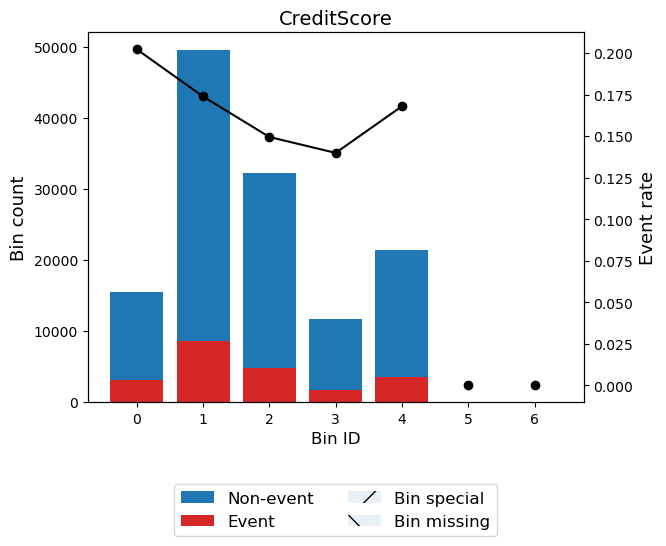

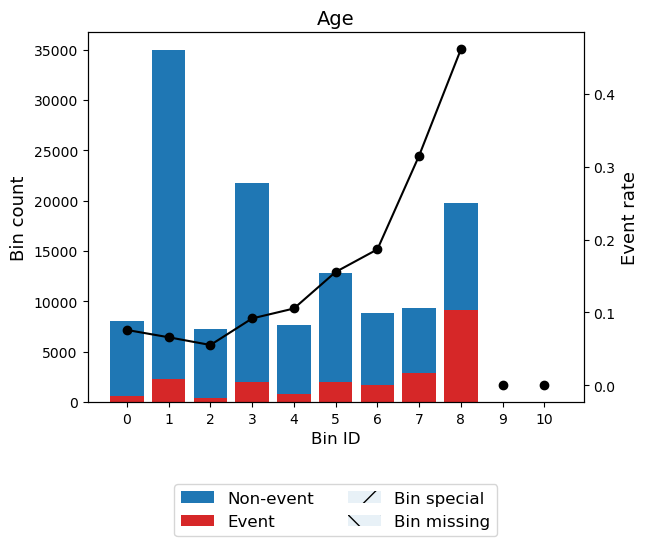

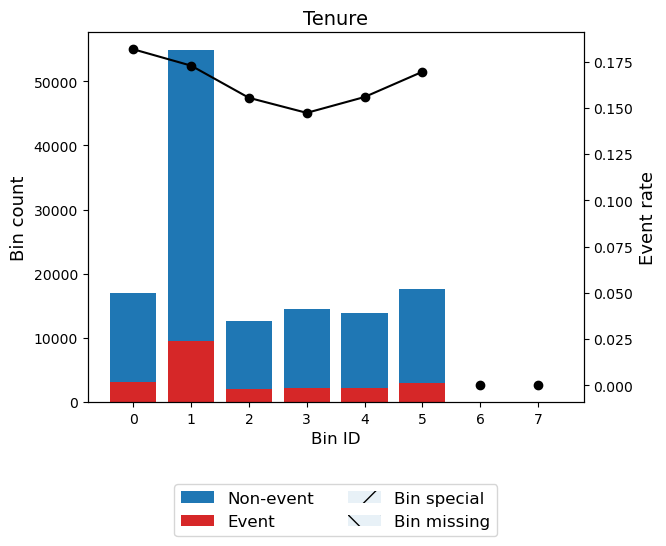

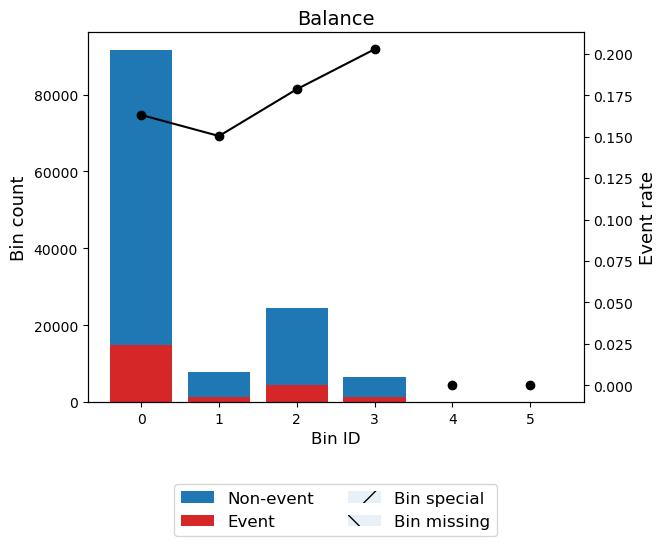

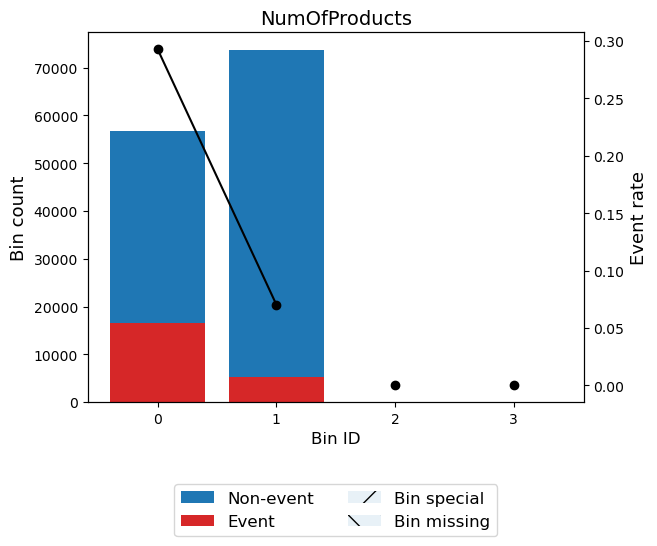

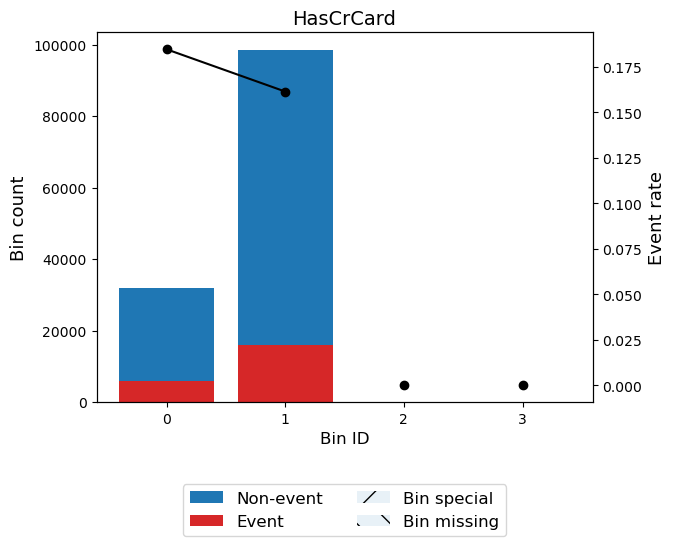

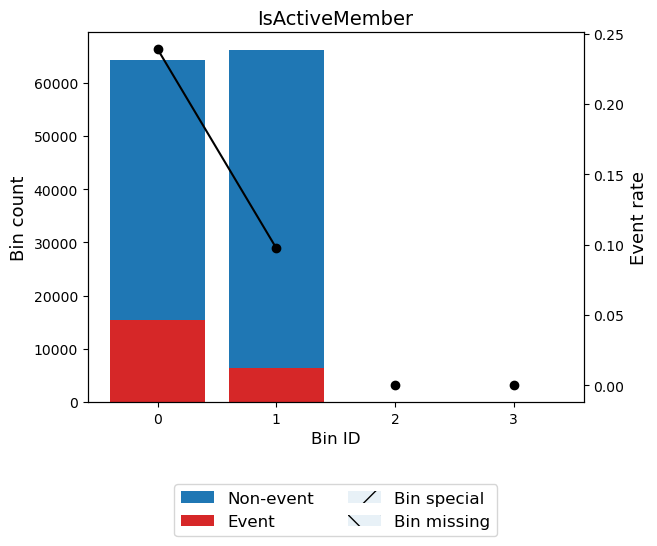

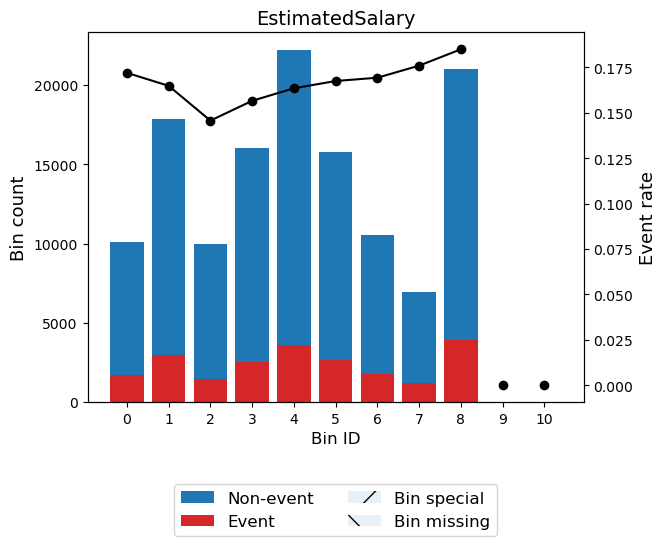

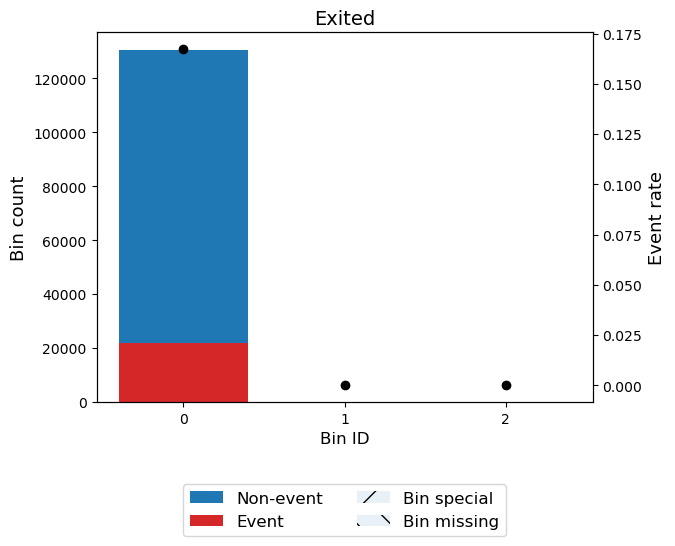

[None, None, None, None, None, None, None, None, None]

In [109]:
analisis_bi_multi.woegrafnum(region01,region01['Exited'])

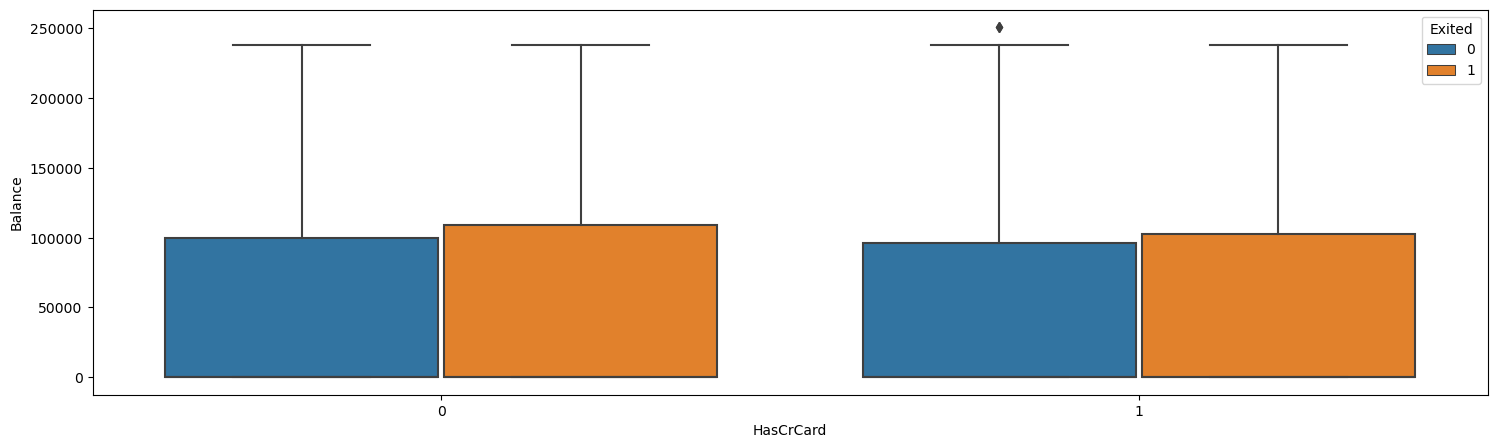

In [110]:
plt.figure(figsize=(18,5))
sns.boxplot(x='HasCrCard',y='Balance',hue='Exited', data=region01)
plt.show()

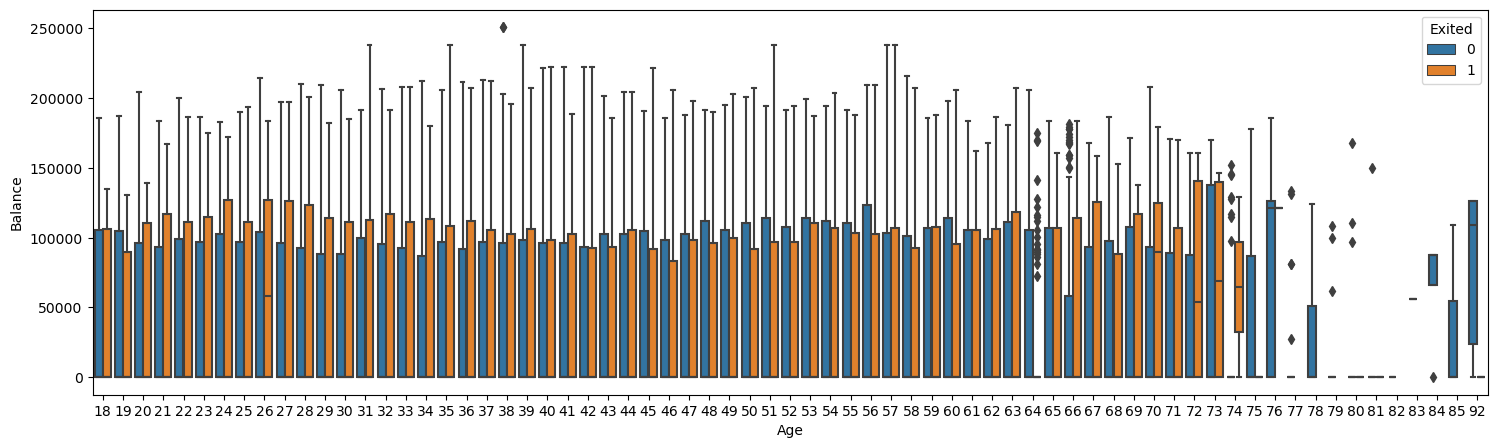

In [111]:
plt.figure(figsize=(18,5))
sns.boxplot(x='Age',y='Balance',hue='Exited', data=region01)
plt.show()

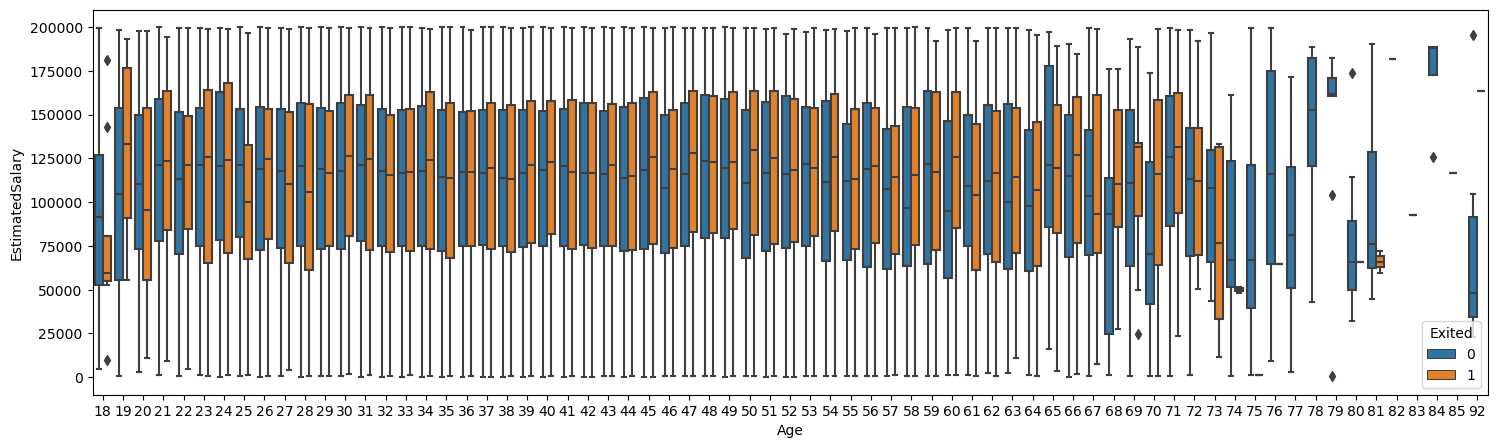

In [112]:
plt.figure(figsize=(18,5))
sns.boxplot(x='Age',y='EstimatedSalary', hue='Exited', data=region01)
plt.show()

In [113]:
analisis_bi_multi.varclus(region01)

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio
0,0,Age,0.655159,0.004508,0.346403
1,0,Exited,0.655159,0.035919,0.357689
2,1,Balance,0.712653,0.000686,0.287545
3,1,NumOfProducts,0.712653,0.035307,0.297864
4,2,EstimatedSalary,1.000000,0.000066,0.000000
5,3,Tenure,1.000000,0.000219,0.000000
6,4,CreditScore,1.000000,0.000523,0.000000
7,5,IsActiveMember,1.000000,0.010522,0.000000
8,6,HasCrCard,1.000000,0.000549,0.000000
9,7,Geography,1.000000,0.000325,0.000000


<Axes: >

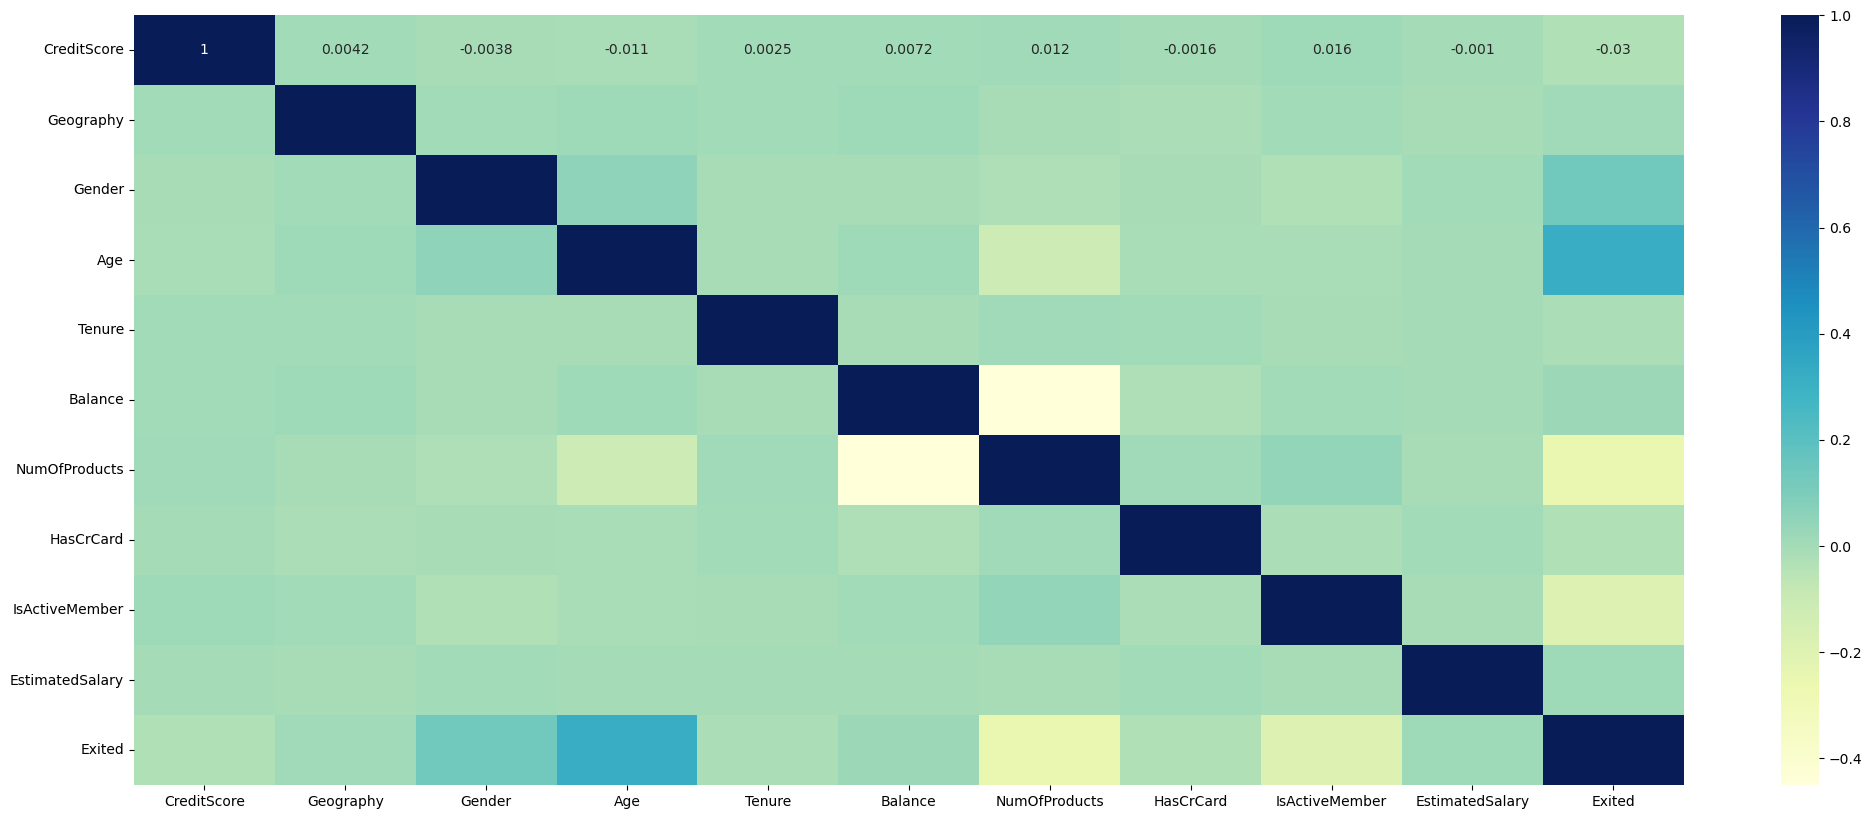

In [114]:
correlation= region01.astype('int64').corr(method='spearman')
plt.figure(figsize=(25,10))
sns.heatmap(correlation, annot=True, cmap= 'YlGnBu')

## Analisis con la Interacción entre Balance y Geography con todo el DataFrame

In [115]:
df_new= df_train

In [116]:
df_new['Balance*HasCrCard']= df_new['Balance']*df_new['HasCrCard']

In [117]:
type(df_new,'Balance*HasCrCard','int64')

In [118]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CreditScore        165034 non-null  int64  
 1   Geography          165034 non-null  object 
 2   Gender             165034 non-null  object 
 3   Age                165034 non-null  int64  
 4   Tenure             165034 non-null  int64  
 5   Balance            165034 non-null  float64
 6   NumOfProducts      165034 non-null  int64  
 7   HasCrCard          165034 non-null  int64  
 8   IsActiveMember     165034 non-null  int64  
 9   EstimatedSalary    165034 non-null  float64
 10  Exited             165034 non-null  int64  
 11  Balance*HasCrCard  165034 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 15.1+ MB


In [119]:
X= df_new.drop(columns=['Exited']).astype('int64')
X = sm.add_constant(X)
y = df_new['Exited']

# Ajustar el modelo lineal con términos de interacción
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Exited   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     4318.
Date:                Mon, 05 Aug 2024   Prob (F-statistic):               0.00
Time:                        19:55:25   Log-Likelihood:                -65527.
No. Observations:              165034   AIC:                         1.311e+05
Df Residuals:                  165022   BIC:                         1.312e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0529      0.01

<Axes: >

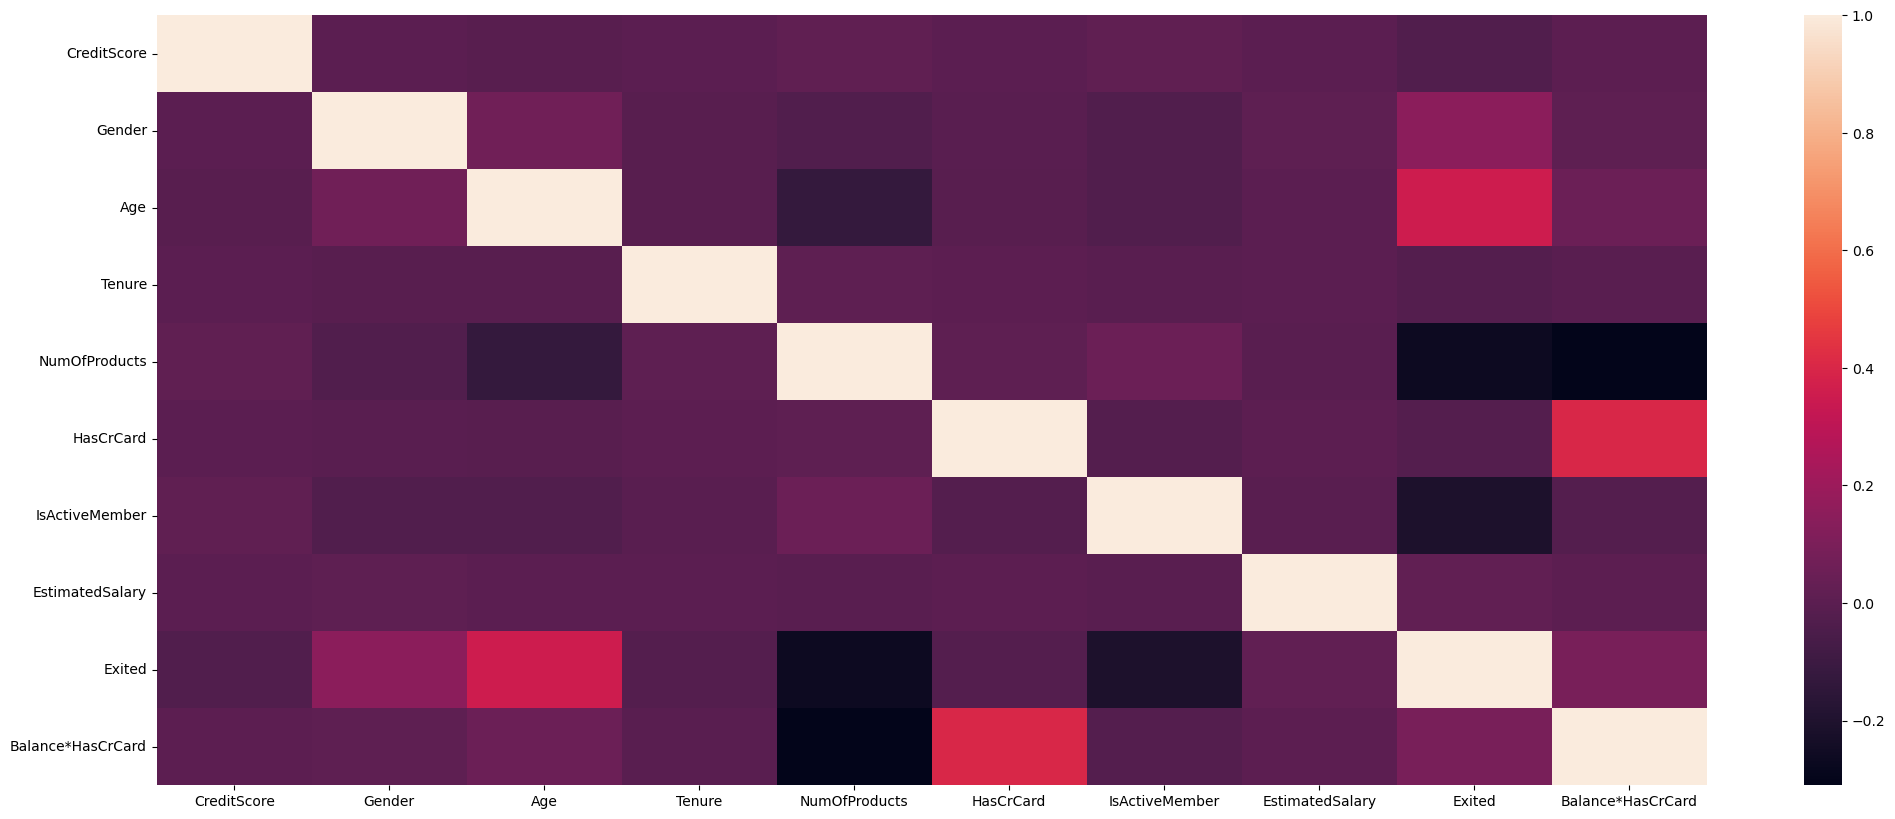

In [120]:
correlation= df_new.drop(columns=['Balance','Geography']).astype('int64').corr(method='spearman')
plt.figure(figsize=(25,10))
sns.heatmap(correlation)

In [121]:
df_new.astype('int64').corr(method='spearman')

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Balance*HasCrCard
CreditScore,1.000000,0.003764,-0.002829,-0.011805,0.000833,0.005613,0.012970,-0.002723,0.014136,-0.001341,-0.029120,0.004229
Geography,0.003764,1.000000,0.033321,0.088287,-0.004756,0.425672,-0.096259,-0.013735,-0.025951,0.006222,0.171098,0.345226
Gender,-0.002829,0.033321,1.000000,0.065142,-0.008791,0.013809,-0.033719,-0.006418,-0.033722,0.009054,0.146442,0.007209
Age,-0.011805,0.088287,0.065142,1.000000,-0.009140,0.065691,-0.128859,-0.011957,-0.029951,-0.000669,0.354666,0.048921
Tenure,0.000833,-0.004756,-0.008791,-0.009140,1.000000,-0.009309,0.007814,0.005217,-0.005618,0.001064,-0.019354,-0.004244
Balance,0.005613,0.425672,0.013809,0.065691,-0.009309,1.000000,-0.381700,-0.016529,-0.014848,0.007332,0.126417,0.787117
NumOfProducts,0.012970,-0.096259,-0.033719,-0.128859,0.007814,-0.381700,1.000000,0.007655,0.050301,-0.004473,-0.266771,-0.310185
HasCrCard,-0.002723,-0.013735,-0.006418,-0.011957,0.005217,-0.016529,0.007655,1.000000,-0.021034,0.003562,-0.022141,0.398410
IsActiveMember,0.014136,-0.025951,-0.033722,-0.029951,-0.005618,-0.014848,0.050301,-0.021034,1.000000,-0.007859,-0.210237,-0.022924
EstimatedSalary,-0.001341,0.006222,0.009054,-0.000669,0.001064,0.007332,-0.004473,0.003562,-0.007859,1.000000,0.019997,0.006646


In [122]:
analisis_bi_multi.correlation(df_new,'Exited')

,Correlation,P-Value
CreditScore,-0.029120,2.663270e-32
Geography,0.171098,0.000000e+00
Gender,0.146442,0.000000e+00
Age,0.354666,0.000000e+00
Tenure,-0.019354,3.744410e-15
Balance,0.126417,0.000000e+00
NumOfProducts,-0.266771,0.000000e+00
HasCrCard,-0.022141,2.344899e-19
IsActiveMember,-0.210237,0.000000e+00
EstimatedSalary,0.019997,4.494482e-16


In [123]:
analisis_bi_multi.varclus(df_new.drop(columns=['Balance','Geography']))

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio
0,0,Age,0.670384,0.010444,0.333095
1,0,Exited,0.670384,0.046034,0.345521
2,1,HasCrCard,0.698726,0.000442,0.301407
3,1,Balance*HasCrCard,0.698726,0.082519,0.328371
4,2,Tenure,1.000000,0.000345,0.000000
5,3,CreditScore,1.000000,0.000491,0.000000
6,4,IsActiveMember,1.000000,0.015967,0.000000
7,5,EstimatedSalary,1.000000,0.000067,0.000000
8,6,Gender,1.000000,0.016380,0.000000
9,7,NumOfProducts,1.000000,0.037415,0.000000


In [124]:
corr= stats.spearmanr(df_new[['Exited','Balance*HasCrCard','HasCrCard']])
corr[0][0]

array([ 1.        ,  0.09337082, -0.02214133])

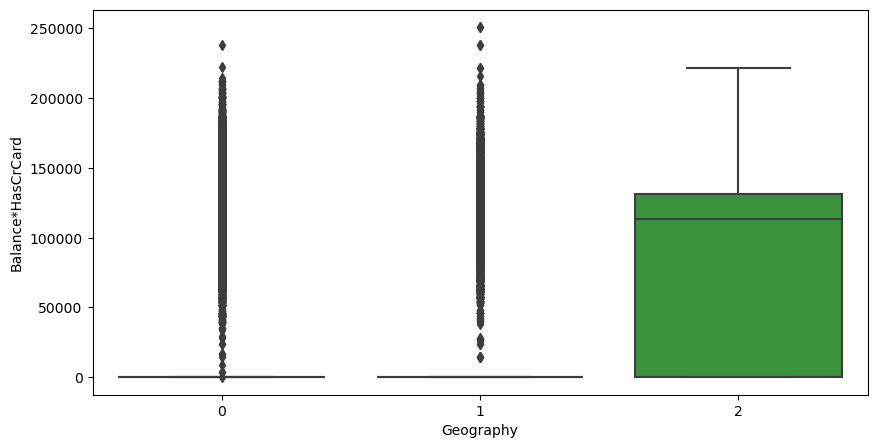

In [125]:
plt.figure(figsize=(10,5))
sns.boxplot(x='Geography',y='Balance*HasCrCard', data=df_new)
plt.show()

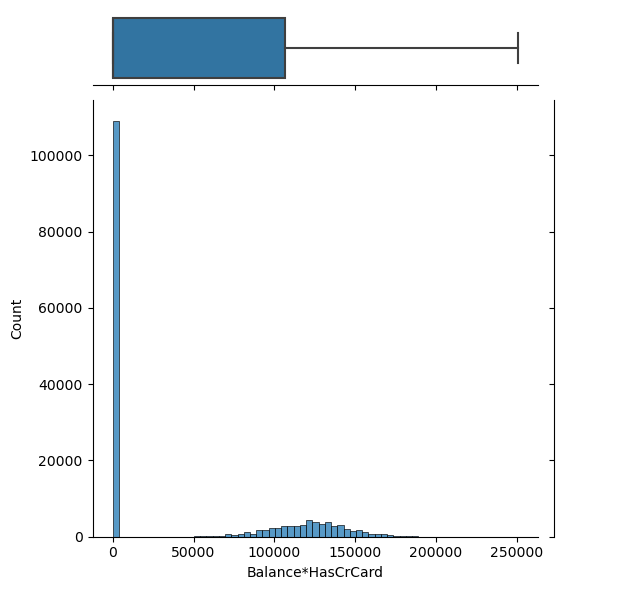

In [126]:
graf_func(df_new,'Balance*HasCrCard')

In [127]:
outliers.quantileoutlier(df_new,'Balance*HasCrCard',1.5).min()

nan

In [128]:
#df_new= df_new[df_new['Balance*HasCrCard']<288703].reset_index(drop=True)

In [129]:
analisis_bi_multi.olstest(df_new,'Exited')

{'CreditScore': <class 'statsmodels.stats.contrast.WaldTestResults'>
                             F                     P>F  df constraint  df denom
 const  [[1335.7310973869944]]  2.868720699710188e-291              1  165032.0
 x      [[123.83496582740675]]   9.373557251147685e-29              1  165032.0,
 'Geography': <class 'statsmodels.stats.contrast.WaldTestResults'>
                             F  P>F  df constraint  df denom
 const  [[14384.547681527396]]  0.0              1  165032.0
 x       [[5970.104569440793]]  0.0              1  165032.0,
 'Gender': <class 'statsmodels.stats.contrast.WaldTestResults'>
                             F  P>F  df constraint  df denom
 const  [[14435.376766960078]]  0.0              1  165032.0
 x       [[3616.693181457383]]  0.0              1  165032.0,
 'Age': <class 'statsmodels.stats.contrast.WaldTestResults'>
                            F  P>F  df constraint  df denom
 const  [[8594.968238277037]]  0.0              1  165032.0
 x      [[

In [130]:
analisis_bi_multi.woenum(df_new,df_new['Exited'])

{'CreditScore':                      Bin   Count  Count (%)  Non-event  Event  Event rate  \
 0         (-inf, 560.50)   19647   0.119048      14842   4805    0.244567   
 1       [560.50, 659.50)   63035   0.381952      49122  13913    0.220719   
 2       [659.50, 709.50)   40174   0.243429      32491   7683    0.191243   
 3       [709.50, 730.50)   14649   0.088764      11969   2680    0.182948   
 4          [730.50, inf)   27529   0.166808      21689   5840    0.212140   
 5                Special       0   0.000000          0      0    0.000000   
 6                Missing       0   0.000000          0      0    0.000000   
 Totals                    165034   1.000000     130113  34921    0.211599   
 
              WoE        IV            JS  
 0      -0.187511  0.004411  5.506214e-04  
 1      -0.053832  0.001124  1.404848e-04  
 2       0.126638  0.003762  4.698748e-04  
 3       0.181188  0.002762  3.447967e-04  
 4      -0.003241  0.000002  2.191594e-07  
 5            0.0

In [131]:
analisis_bi_multi.woecat(df_new,df_new['Exited'])

{'Geography':             Bin   Count  Count (%)  Non-event  Event  Event rate       WoE  \
 0           [0]   94215   0.570882      78643  15572    0.165282  0.304129   
 1           [1]   36213   0.219428      29978   6235    0.172176   0.25497   
 2           [2]   34606   0.209690      21492  13114    0.378952 -0.821315   
 3       Special       0   0.000000          0      0    0.000000       0.0   
 4       Missing       0   0.000000          0      0    0.000000       0.0   
 Totals           165034   1.000000     130113  34921    0.211599             
 
               IV        JS  
 0       0.048204  0.006002  
 1       0.013221  0.001648  
 2       0.172767  0.021009  
 3       0.000000  0.000000  
 4       0.000000  0.000000  
 Totals  0.234192  0.028659  ,
 'Gender':             Bin   Count  Count (%)  Non-event  Event  Event rate       WoE  \
 0           [0]   93150   0.564429      78334  14816    0.159055  0.349959   
 1           [1]   71884   0.435571      51779  20105

Conclusiones:

* Balance y HasCrCard junto a Geography tiene una interacción que nos puede afectar al momento del modelado.
    * Para ser exactos dentro de la región 2 Germany.
    * Esto puede ser debido a una mala recolección de datos para la muestra.

* HasCrCard dentro de la Variable Clustering Technique demuestra tener una correlación muy baja ante la variable objetivo.

* Determinamos que las variables de mayor importancia dado el análisis estadistico anterior son:
    * Geography, Gender, Age, Balance, NumOfProducts, IsActiveMember.